In [ ]:
pip install -e . --user

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import elpigraph
import sys
import stream as st
import plotly.express as px
sys.path.insert(0,'../../STREAM2/notebooks/')
import elpigraph_v2
#%load_ext rpy2.ipython

In [2]:
#-------generate data, data labels, pseudotime
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
pseudotime = X[:,1]+np.abs(X[:,0])

In [490]:
%timeit pg3=elpigraph.computeElasticPrincipalTree(X+0.0001*np.random.random(),30,FixNodesAtPoints=[[0]],pseudotime=pseudotime,pseudotimeLambda=10)[0]

33 s ± 8.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%time pg3=elpigraph.computeElasticPrincipalTree(X+0.0001*np.random.random(),50,)[0]

CPU times: user 1min 12s, sys: 1min 1s, total: 2min 14s
Wall time: 11.6 s


In [10]:
%time pg3=elpigraph.computeElasticPrincipalTree(X+0.0001*np.random.random(),50,FixNodesAtPoints=[[150]],pseudotime=pseudotime,pseudotimeLambda=10)[0]

CPU times: user 4min 32s, sys: 3min 44s, total: 8min 16s
Wall time: 42.4 s


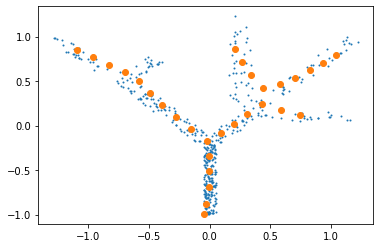

In [7]:
plt.scatter(*X.T,s=1)
plt.scatter(*pg3['NodePositions'].T)

In [13]:
%time pg1=elpigraph.computeElasticPrincipalTree(X,30)[0]
%time pg2=elpigraph.computeElasticPrincipalTree(X,30,FixNodesAtPoints=[[0]])[0]
%time pg3=elpigraph.computeElasticPrincipalTree(X,30,FixNodesAtPoints=[[0]],pseudotime=pseudotime,pseudotimeLambda=10)[0]

CPU times: user 32.8 s, sys: 29 s, total: 1min 1s
Wall time: 5.47 s


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/_topologies.py", line 458, in computeElasticPrincipalTree
    MaxNumberOfGraphCandidatesDict=MaxNumberOfGraphCandidatesDict,
  File "/mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/_BaseElPiWrapper.py", line 397, in computeElasticPrincipalGraphWithGrammars
    MaxNumberOfGraphCandidatesDict=MaxNumberOfGraphCandidatesDict,
  File "/mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/src/BaseElPi.py", line 893, in computeElasticPrincipalGraph
    MaxNumberOfGraphCandidatesDict=MaxNumberOfGraphCandidatesDict,
  File "/mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/src/BaseElPi.py", line 348, in ElPrincGraph
    MaxNumberOfGraphCandidatesDict=MaxNumberOfGraphCan

TypeError: object of type 'NoneType' has no len()

In [5]:
import pickle
with open('epg.pkl','rb') as f:
    _pg1,_pg2,_pg3=pickle.load(f)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from scipy.sparse.csgraph import shortest_path
import matplotlib.colors as mcol
from matplotlib import cm
from ot.gromov import fgw_barycenters

def find_thresh(C, inf=0.5, sup=3, step=10):
    """ Trick to find the adequate thresholds from where value of the C matrix are considered close enough to say that nodes are connected
        Tthe threshold is found by a linesearch between values "inf" and "sup" with "step" thresholds tested.
        The optimal threshold is the one which minimizes the reconstruction error between the shortest_path matrix coming from the thresholded adjency matrix
        and the original matrix.
    Parameters
    ----------
    C : ndarray, shape (n_nodes,n_nodes)
            The structure matrix to threshold
    inf : float
          The beginning of the linesearch
    sup : float
          The end of the linesearch
    step : integer
            Number of thresholds tested
    """
    dist = []
    search = np.linspace(inf, sup, step)
    for thresh in search:
        Cprime = sp_to_adjency(C, 0, thresh)
        SC = shortest_path(Cprime, method='D')
        SC[SC == float('inf')] = 100
        dist.append(np.linalg.norm(SC - C))
    return search[np.argmin(dist)], dist


def sp_to_adjency(C, threshinf=0.2, threshsup=1.8):
    """ Thresholds the structure matrix in order to compute an adjency matrix.
    All values between threshinf and threshsup are considered representing connected nodes and set to 1. Else are set to 0
    Parameters
    ----------
    C : ndarray, shape (n_nodes,n_nodes)
        The structure matrix to threshold
    threshinf : float
        The minimum value of distance from which the new value is set to 1
    threshsup : float
        The maximum value of distance from which the new value is set to 1
    Returns
    -------
    C : ndarray, shape (n_nodes,n_nodes)
        The threshold matrix. Each element is in {0,1}
    """
    H = np.zeros_like(C)
    np.fill_diagonal(H, np.diagonal(C))
    C = C - H
    C = np.minimum(np.maximum(C, threshinf), threshsup)
    C[C == threshsup] = 0
    C[C != 0] = 1

    return C


def build_noisy_circular_graph(N=20, mu=0, sigma=0.3, with_noise=False, structure_noise=False, p=None):
    """ Create a noisy circular graph
    """
    g = nx.Graph()
    g.add_nodes_from(list(range(N)))
    for i in range(N):
        noise = float(np.random.normal(mu, sigma, 1))
        if with_noise:
            g.add_node(i, attr_name=math.sin((2 * i * math.pi / N)) + noise)
        else:
            g.add_node(i, attr_name=math.sin(2 * i * math.pi / N))
        g.add_edge(i, i + 1)
        if structure_noise:
            randomint = np.random.randint(0, p)
            if randomint == 0:
                if i <= N - 3:
                    g.add_edge(i, i + 2)
                if i == N - 2:
                    g.add_edge(i, 0)
                if i == N - 1:
                    g.add_edge(i, 1)
    g.add_edge(N, 0)
    noise = float(np.random.normal(mu, sigma, 1))
    if with_noise:
        g.add_node(N, attr_name=math.sin((2 * N * math.pi / N)) + noise)
    else:
        g.add_node(N, attr_name=math.sin(2 * N * math.pi / N))
    return g


def graph_colors(nx_graph, vmin=0, vmax=7):
    cnorm = mcol.Normalize(vmin=vmin, vmax=vmax)
    cpick = cm.ScalarMappable(norm=cnorm, cmap='viridis')
    cpick.set_array([])
    val_map = {}
    for k, v in nx.get_node_attributes(nx_graph, 'attr_name').items():
        val_map[k] = cpick.to_rgba(v)
    colors = []
    for node in nx_graph.nodes():
        colors.append(val_map[node])
    return colors

X = np.genfromtxt('data/circle_data.csv', delimiter=',')[:,:2]


In [ ]:
a=sc.AnnData(X)
sc.pp.neighbors(a)
sc.tl.leiden(a)
sc.tl.paga(a)

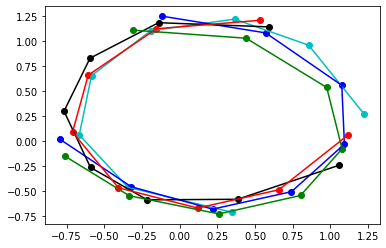

In [ ]:
epg=elpigraph.computeElasticPrincipalTree(X,8,ProbPoint=.3,nReps=5,Do_PCA=False,CenterData=False)

#plt.scatter(*X.T)
cols=iter(['c','b','k','g','r',''])
for e in epg[:-1]:
    nodep=e['NodePositions']
    edges=e['Edges'][0]
    c=next(cols)
    plt.scatter(*nodep.T,c=c)
    for _e in edges:
        curve=nodep[_e].T
        plt.plot(curve[0],curve[1],c=c)

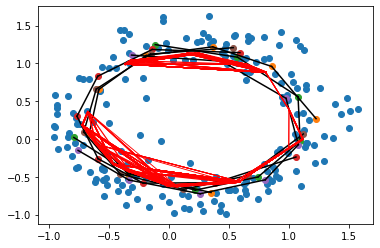

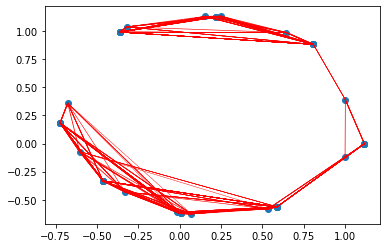

In [ ]:
X0 = []
Ys = []
for e in epg[:-1]:
    nodep=e['NodePositions']
    edges=e['Edges'][0]
    g = nx.Graph()
    g.add_nodes_from(list(range(len(nodep))))
    g.add_edges_from(edges.tolist())
    X0.append(g)
    Ys.append(nodep)

Cs = [shortest_path(nx.adjacency_matrix(x)) for x in X0]
ps = [np.ones(len(x.nodes())) / len(x.nodes()) for x in X0]
#Ys = [np.array([v for (k, v) in nx.get_node_attributes(x, 'attr_name').items()]).reshape(-1, 1) for x in X0]
lambdas = np.array([np.ones(len(Ys)) / len(Ys)]).ravel()
sizebary = 50  # we choose a barycenter with 15 nodes

A, C, log = fgw_barycenters(sizebary, Ys, Cs, ps, lambdas, alpha=.01, log=True)

C_filtered=sp_to_adjency(C, threshinf=0, threshsup=find_thresh(C, sup=100, step=100)[0])


S = 1-C/C.max()
#bary = nx.from_numpy_matrix(sp_to_adjency(C_filtered, threshinf=0, threshsup=find_thresh(C, sup=100, step=100)[0]))
#bary = nx.from_numpy_matrix(sp_to_adjency(C, threshinf=1, threshsup=2))
bary = nx.from_numpy_matrix(C_filtered)
for i, v in enumerate(A):
    bary.add_node(i, attr_name=v)
    
plt.scatter(*X.T)

for e in epg[:-1]:
    nodep=e['NodePositions']
    edges=e['Edges'][0]
    plt.scatter(*nodep.T)
    for _e in edges:
        curve=nodep[_e].T
        plt.plot(curve[0],curve[1],c='k')
        
bnodes=np.array(list(nx.get_node_attributes(bary,'attr_name').values()))
bedges=np.array(bary.edges)
for _e in bedges:
    curve=bnodes[_e].T
    plt.plot(curve[0],curve[1],c=c,linewidth=2*S[_e[0],_e[1]])
    
plt.show()
plt.scatter(*bnodes.T)
for _e in bedges:
    curve=bnodes[_e].T
    plt.plot(curve[0],curve[1],c=c,linewidth=S[_e[0],_e[1]])

In [ ]:
import sys
sys.path.append('../MinScaffold/src') # add the source code to the path
# These are the main files in MinScaffold/src/
import Driver
import Geometry
import Scaffold

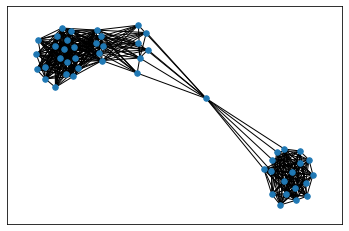

In [ ]:
G = nx.from_numpy_array(W) # create a nx object
layout = nx.drawing.layout.spring_layout(G)
nx.draw_networkx(G,with_labels = False, node_size = 30)

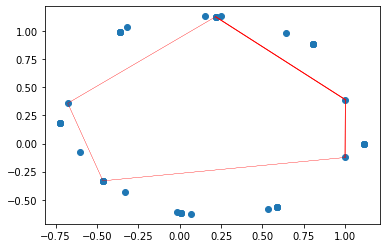

In [ ]:
bedges=np.vstack(M.nonzero()).T

plt.scatter(*bnodes.T)
for _e in bedges:
    curve=bnodes[_e].T
    plt.plot(curve[0],curve[1],c=c,linewidth=S[_e[0],_e[1]]/10)

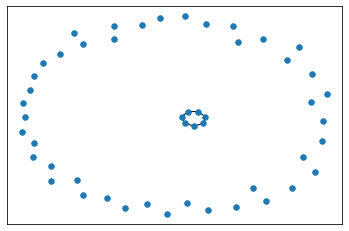

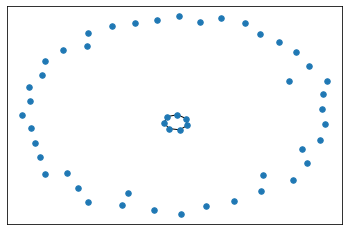

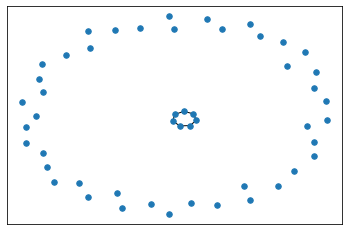

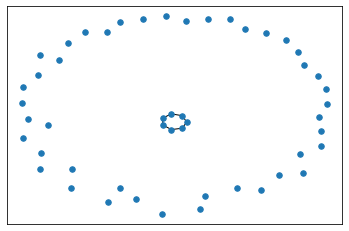

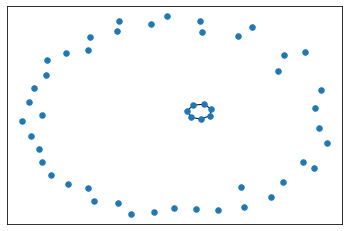

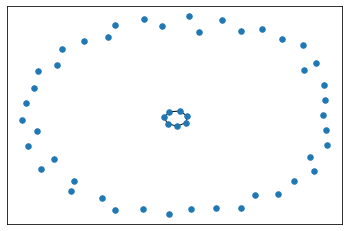

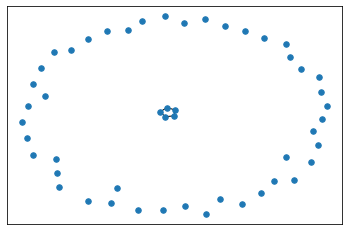

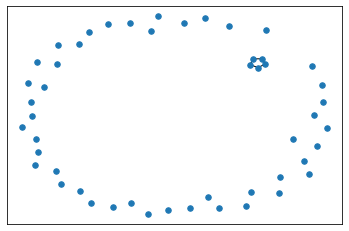

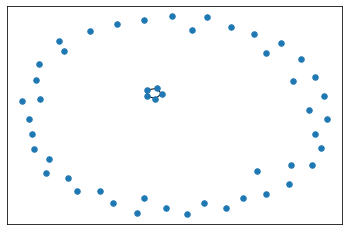

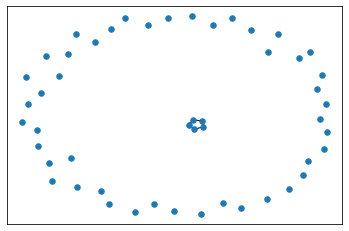

In [ ]:
i = 0
for (e,B) in F.Elements:
    i += 1
    fig , ax1= plt.subplots()
    M = Scaffold.matrix_Basis( B , W.shape[1] , np.array(F.get_edgeList()) )
    nx.draw_networkx(nx.Graph(M),with_labels = False, node_size = 30)

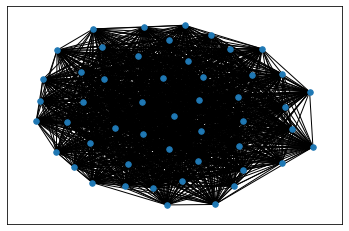

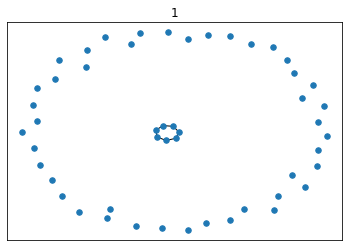

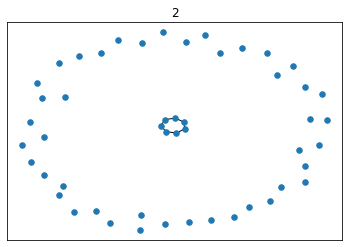

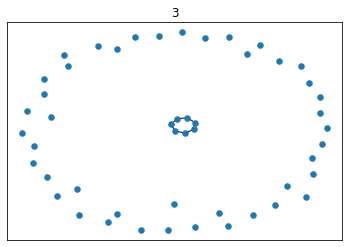

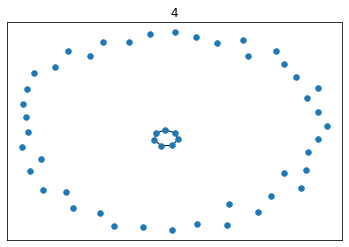

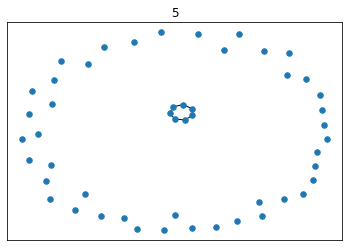

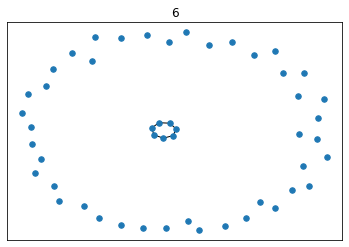

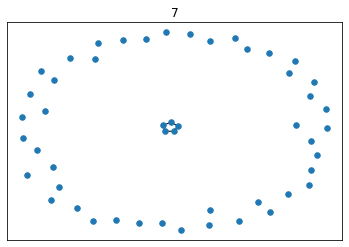

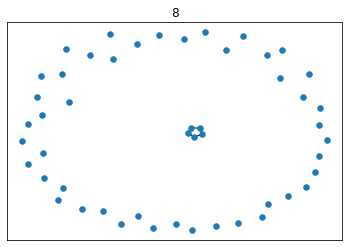

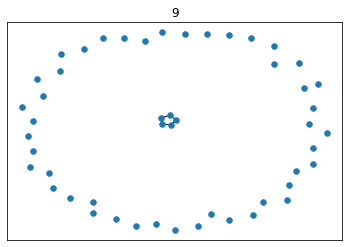

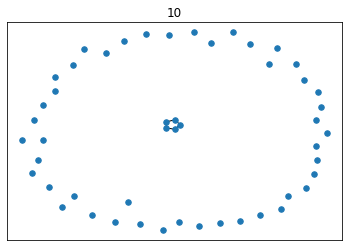

In [ ]:
W=C
np.fill_diagonal(W,0)
epsList = Geometry.genFullEpsList(W)[130:140]
F = Driver.getFiltrBasis(W, epsList, Draws=False, parallel=True, monitor=None)
S = Scaffold.frequency_Scaffold(F , W.shape[0])
Scaf = nx.from_numpy_matrix(S, parallel_edges=False)
G = nx.Graph(W) # create a nx object
nx.draw_networkx(G,with_labels = False, node_size = 30)

# Create a list of homology bases
Bas = []
for (step,B) in F.Elements: 
    Bas.append(B) # store the basis, discarding the filtration step value
    
i = 0
for (e,B) in F.Elements:
    i += 1
    fig , ax1= plt.subplots()
    M = Scaffold.matrix_Basis( B , W.shape[1] , np.array(F.get_edgeList()) )
    nx.draw_networkx(nx.Graph(M),with_labels = False, node_size = 30)
    plt.title(i)
    plt.show()

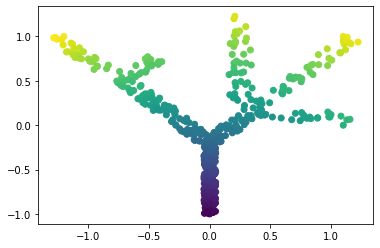

In [ ]:
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
X = np.concatenate(([[0,-1],[.2,1.2],[-1.2,1],[1.1,0],[1.1,1]],X))
pseudotime = np.array([np.linalg.norm(X[0]-x) for x in X])
PointWeights=np.arange(len(X))[:,None]

spg=elpigraph.computeElasticPrincipalTree(X,30,
                                      FixNodesAtPoints=[[np.argmin(pseudotime)]],#PointWeights=pseudotime[:,None],
                                      pseudotime=pseudotime,pseudotimeLambda=0.1,StoreGraphEvolution=True,
                                      MaxNumberOfGraphCandidatesDict={'AddNode2Node': 20, 'BisectEdge': 20, 'ShrinkEdge':20})[0]
plt.scatter(*X.T,c=pseudotime)

In [ ]:
anim=elpigraph_v2.animate_spg(X,pseudotime,spg)

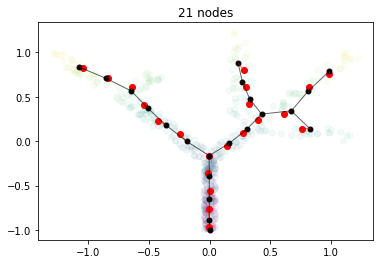

In [ ]:
next(anim)

In [ ]:
import os

files = os.listdir('../../STREAM2/data/ewing/moduleAverages/')
ewings = []
for f in files:
    ewings.append(np.array(pd.read_csv('../../STREAM2/data/ewing/moduleAverages/'+f,sep='\t')[['IC1+','IC2+','IC3+']]))

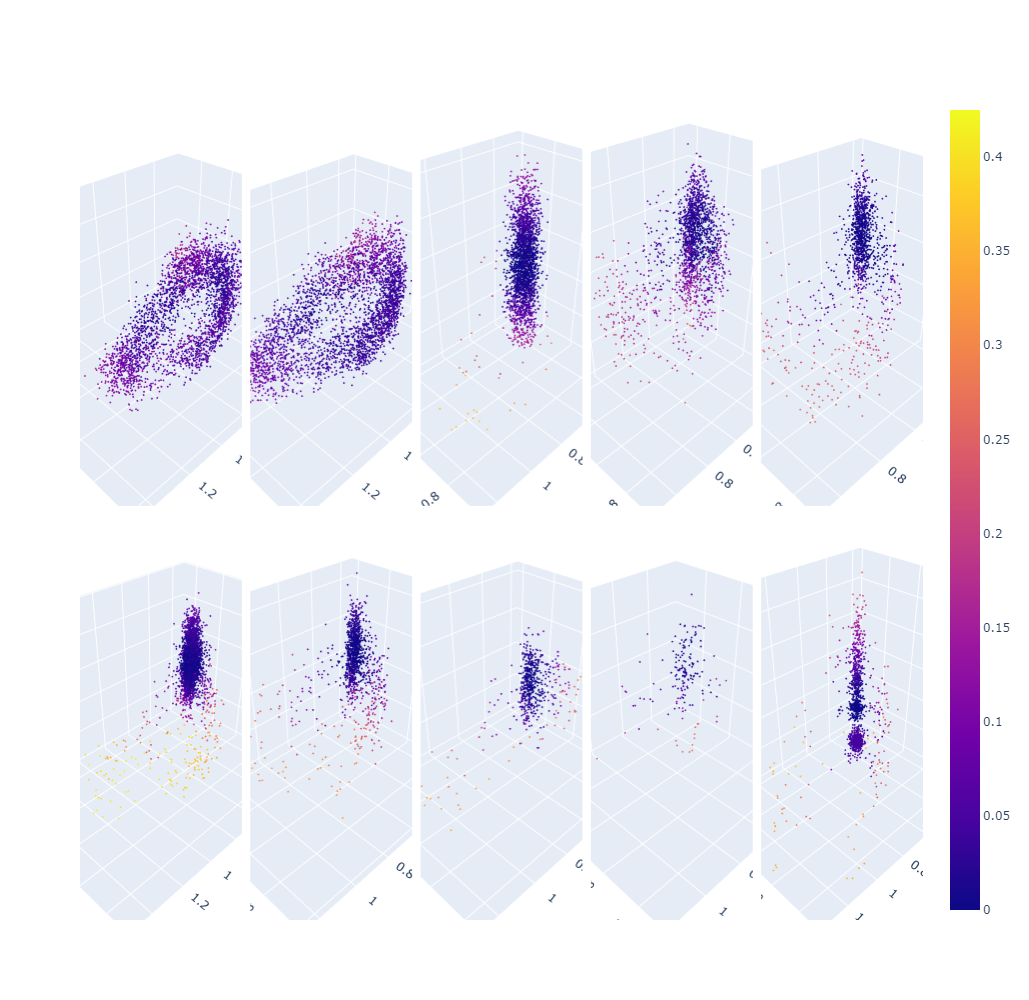

In [ ]:
from sklearn.neighbors import KernelDensity
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=5,specs=[[{'type': 'Scatter3d'}]*5]*2,
                    vertical_spacing=0.01, horizontal_spacing=0.01)

ewings_scores = []
for i,X in enumerate(ewings):
    _anndata = sc.AnnData(X)
    _anndata.obs['pc1']=sklearn.decomposition.PCA().fit_transform(X)[:,0]

    pw=1
    kde = KernelDensity(kernel='gaussian',bandwidth=.5).fit(X)
    scores = kde.score_samples(X)
    scores = np.exp(scores)[:,None]
    scores = -scores+scores.max()+1e-30
    #scores = (-scores/scores.max()) +1
    #scores = scores*pw +1
    ewings_scores.append(scores)
    _i,_j = np.unravel_index(i,(2,5))
    fig.add_trace(px.scatter_3d(x=X[:,0],y=X[:,1],z=X[:,2],color=scores.flat).data[0],row=_i+1,col=_j+1)
fig.update_traces(marker=dict(size=1))
fig.layout.update(height=1000, width=1200)
fig.write_html('ewings.html')
fig

In [ ]:
labels=pd.read_csv('/mnt/c/Users/jobac/Downloads/My_favorite_cells.16220394789/cell_groupings.csv',header=None).set_index([0]).T

In [ ]:
adata=sc.read('/mnt/c/Users/jobac/Downloads/My_favorite_cells.16220394789/expr.csv').T
adata.obs=labels

NameError: name 'labels' is not defined

# Fixing nodes

In [ ]:
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
X = np.concatenate(([[1.2,0],
                     [1,1],
                     [0,1]],
                    X))
#X = np.concatenate((np.zeros(25)[None],np.linspace(-1,1,25)[None]),axis=0).T

PointWeights=np.ones(len(X))[None].T
NodePositions=np.array([[-1, 0],
                        [0, -1],
                        [1, 1],
                        [1, .5]])
Edges = np.array([[0,1],
                  [1,2],
                  [2,3]])

SquaredX=np.sum(X**2,axis=1,keepdims=1)
FixNodesAtPoints=[[0, 1, 2, 3, 4, 5],[-1,-2,-3,-4,-5]]
#FixNodesAtPoints=[np.arange(20)]
flat_FixNodesAtPoints = [item for sublist in FixNodesAtPoints for item in sublist] #fixed datapoints
if len(set(flat_FixNodesAtPoints)) != len(flat_FixNodesAtPoints):
    raise ValueError('FixNodesAtPoints lists contain duplicate points')
    
FixedNodePositions = np.array([X[inds].mean(axis=0) for inds in FixNodesAtPoints]) #init fixed nodes 
NodePositions=np.concatenate((FixedNodePositions,NodePositions))

Edges = np.concatenate(([[0,1],[1,2]],Edges+len(FixNodesAtPoints)))
SpringLaplacianMatrix = elpigraph.src.core.MakeUniformElasticMatrix(Edges,.1,.1)

In [ ]:
partition, dists = elpigraph.src.core.PartitionData(X,NodePositions,SquaredX=SquaredX,MaxBlockSize=1000000)

# Local data is the data that does not belong to the fixed nodes
# LocalInds is logical index with value true for data points which
# does not correspond to complement of selected set of nodes
# NodeSubSet.
# NodeSubSet is array with numbers of nodes to position optimisation.

#-----Index data and graph into moving nodes and fixed nodes------#
#set of points to fit or keep fixed
flat_FixNodesAtPoints = [item for sublist in FixNodesAtPoints for item in sublist] #fixed datapoints
move_data_idx = [i for i in range(len(X)) if i not in flat_FixNodesAtPoints]
move_nodes_idx = np.arange(len(FixNodesAtPoints),len(NodePositions))
fixed_nodes_idx = np.arange(len(FixNodesAtPoints))
#extract corresponding part of arrays
move_X, move_PointWeights, move_SquaredX, move_NodePositions = X[move_data_idx,:], PointWeights[move_data_idx], SquaredX[move_data_idx], NodePositions[move_nodes_idx]
move_nPoints = len(move_data_idx)
move_partition, move_dists = elpigraph.src.core.PartitionData(move_X,move_NodePositions,SquaredX=move_SquaredX,MaxBlockSize=1000000)
#------Fit-------#

def FitSubGraph2DataGivenPartition(move_X, move_PointWeights, SpringLaplacianMatrix, NodePositions, move_partition, move_nodes_idx):
    """
    Fits moving Subpart of the graph to data while constraining some nodes to remain fixed
    """

    #params 
    NumberOfNodes = len(NodePositions)
    NumberOfNodesSubSet = len(move_nodes_idx)
    NumberOfFixedNodes = NumberOfNodes-NumberOfNodesSubSet
    #new node positions
    NewNodePositions = np.zeros(NodePositions.shape)
    
    #weighted average of moving nodes
    move_NodeClusterCenters, move_NodeClusterRelativeSize = elpigraph.src.core.ComputeWeightedAverage(
        move_X, move_partition, move_PointWeights, NumberOfNodesSubSet
    )

    #SLAUMatrices
    rs = np.zeros((NumberOfNodes))
    rs[move_nodes_idx] = move_NodeClusterRelativeSize.flatten()
    SLAUMatrix  = np.diag(rs)+SpringLaplacianMatrix   
    move_SLAUMatrix = SLAUMatrix[move_nodes_idx][:,move_nodes_idx]
    fixed_SLAUMatrix = SLAUMatrix[move_nodes_idx][:,fixed_nodes_idx]

    #Fit
    RightHandSide = move_NodeClusterRelativeSize * move_NodeClusterCenters
    rhs1 = NodePositions[fixed_nodes_idx]
    RightHandSide -= np.dot(fixed_SLAUMatrix, rhs1)
    move_NewNodePositions = np.linalg.solve(move_SLAUMatrix, RightHandSide)
    
    #Store
    NewNodePositions[fixed_nodes_idx, :] = NodePositions[fixed_nodes_idx, :]
    NewNodePositions[move_nodes_idx, :] = move_NewNodePositions
    
    return NewNodePositions

FitSubGraph2DataGivenPartition(move_X, move_PointWeights, SpringLaplacianMatrix, NodePositions, move_partition, move_nodes_idx)

array([[-0.26859797,  0.82385726],
       [ 1.16464432,  0.76838245],
       [-0.78628375,  0.25450212],
       [ 0.19098865, -0.62105184],
       [-0.3040868 ,  0.78462493],
       [ 0.6489423 , -0.08047602]])

# Pseudotime nodes trick
- Small edge between fixed nodes and normal nodes ?

Next things to do
- Modify PartitionData to optimize assignment like barycentric k-means ?
- How to take into account velocity information
- How to deal with categorical labels

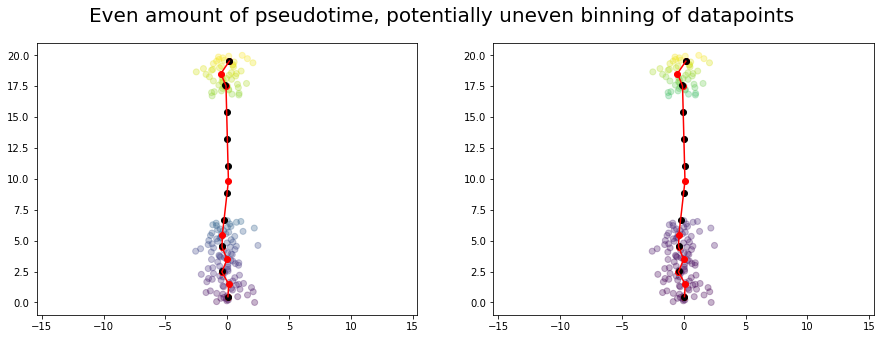

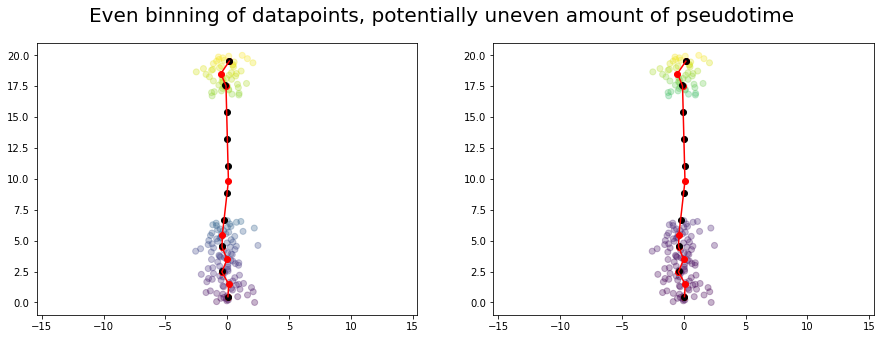

In [ ]:
n=300
nnodes = 10
X=np.concatenate(
    (
    np.random.normal(size=(n))[:,None],
    np.linspace(0,20,n)[:,None]
    ),axis=1)
pseudotime0=X[:,1]
pseudotime1=X[:,1]**2
X_trunc = np.concatenate((X[:100],X[-50:]))
ps_trunc0 = np.concatenate((pseudotime0[:100],pseudotime0[-50:]))
ps_trunc1 = np.concatenate((pseudotime1[:100],pseudotime1[-50:]))


def interp_bins(nodes):
    """interpolate nodes evenly"""
    #euclidean distances between consecutive points
    dist = np.sqrt(
             (np.diff(nodes,axis=0)**2).sum(axis=1)
            )
    u = np.cumsum(dist)
    u = np.hstack([[0],u])
    t = np.linspace(0,u.max(),len(nodes))
    return np.array([np.interp(t, u, coord) for coord in nodes.T]).T

for i in range(2):
    f,ax = plt.subplots(1,2,figsize=(15,5))
    if i==0:
        plt.suptitle('Even amount of pseudotime, potentially uneven binning of datapoints',fontsize=20)
        nodesp0, _ = elpigraph.src.supervised.bin_pseudotime(X_trunc,ps_trunc0,nnodes)
        nodesp1, _ = elpigraph.src.supervised.bin_pseudotime(X_trunc,ps_trunc1,nnodes)

    else:
        plt.suptitle('Even binning of datapoints, potentially uneven amount of pseudotime',fontsize=20)
        nodesp0, _ = elpigraph.src.supervised.nNodes_pseudotime(X_trunc,ps_trunc0,nnodes)
        nodesp1, _ = elpigraph.src.supervised.nNodes_pseudotime(X_trunc,ps_trunc1,nnodes)

    ax[0].scatter(*X_trunc.T,alpha=.3,c=ps_trunc0)
    ax[0].scatter(*nodesp0.T,c='r');ax[0].axis('equal')
    ax[0].plot(*nodesp0.T,c='r');ax[0].axis('equal')
    ax[0].scatter(*interp_bins(nodesp0).T,c='k');ax[0].axis('equal')
    ax[1].scatter(*X_trunc.T,alpha=.3,c=ps_trunc1)
    ax[1].plot(*nodesp1.T,c='r');ax[0].axis('equal')
    ax[1].scatter(*nodesp1.T,c='r');ax[0].axis('equal')
    ax[1].scatter(*interp_bins(nodesp1).T,c='k');ax[1].axis('equal')
    plt.show()

## Single branch version

In [ ]:
MSE = dists.sum() / dists.size
Mu = np.diag(ElasticMatrix)
Lambda = np.triu(ElasticMatrix, 1)
StarCenterIndices = (Mu > 0).nonzero()[0]
(row, col) = Lambda.nonzero()
dev = NodePositions[row] - NodePositions[col]
L = np.zeros((len(row)))
for i in range(len(row)):
    L[i] = Lambda[row[i], col[i]]
### diff compared to base function
BinEM = (Lambda + Lambda.transpose()) > 0
Ks = BinEM.sum(axis=0)
lp = np.maximum(Ks[row], Ks[col])
lp = lp - 2
lp[np.where(lp < 0)] = 0

Lpenalized = L + alpha * lp
EP = np.dot(Lpenalized, np.sum(dev ** 2, axis=1))
####
indL = Lambda + Lambda.transpose() > 0
RP = 0
for i in range(StarCenterIndices.size):
    leaves = indL[StarCenterIndices[i]]
    ind_leaves = leaves.nonzero()[0]
    K = ind_leaves.size
    dev_ = NodePositions[StarCenterIndices[i]] - (
        NodePositions[ind_leaves] / K
    ).sum(axis=0)
    RP += Mu[StarCenterIndices[i]] * (K ** beta) * (dev_ ** 2).sum()

ElasticEnergy = MSE + EP + RP

Signature:
elpigraph.src.core.PrimitiveElasticGraphEmbedment_v2(
    X,
    NodePositions,
    ElasticMatrix,
    MaxNumberOfIterations=10,
    eps=0.01,
    Mode=1,
    FinalEnergy='Base',
    alpha=0,
    beta=0,
    prob=1,
    DisplayWarnings=True,
    PointWeights=None,
    MaxBlockSize=100000000,
    verbose=False,
    TrimmingRadius=inf,
    SquaredX=None,
    FixNodesAtPoints=None,
    PseudotimeNodePositions=None,
    PseudotimeLambda=None,
)
Source:   
def PrimitiveElasticGraphEmbedment_v2(
    X,
    NodePositions,
    ElasticMatrix,
    MaxNumberOfIterations=10,
    eps=0.01,
    Mode=1,
    FinalEnergy="Base",
    alpha=0,
    beta=0,
    prob=1,
    DisplayWarnings=True,
    PointWeights=None,
    MaxBlockSize=100000000,
    verbose=False,
    TrimmingRadius=float("inf"),
    SquaredX=None,
    FixNodesAtPoints=None,
    PseudotimeNodePositions=None,
    PseudotimeLambda=None,
):

    """
    #' Function fitting a primitive elastic graph to the data
    #'
    #' @param X

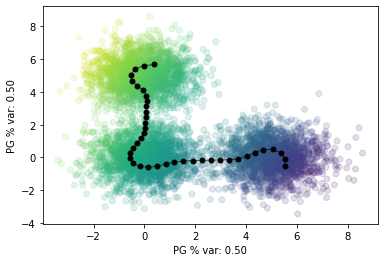

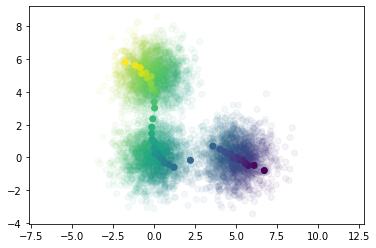

reorienting


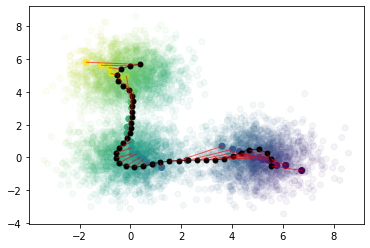

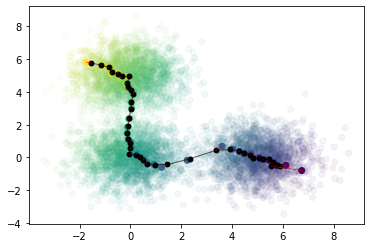

In [2]:
import stream as st
import networkx as nx
import igraph

#-------generate data
n=2000
for i,coo in enumerate([(0,0),(5,0),(0,5)]):
    if i==0: X=np.random.normal(coo,size=(n,2))
    else: X=np.concatenate((X,np.random.normal(coo,size=(n,2))))

#-------data labels, pseudotime
color=np.zeros(len(X),dtype=int)
for i in range(0,len(X),n):
    color[i:i+n]=i/n
pseudotime = X[:,1]-X[:,0]*2

#------compute example elpigraph curve (corresponding to elpigraph branch)
pg=elpigraph.computeElasticPrincipalCurve(X,40,Lambda=.1)[0]
NodePositions = pg['NodePositions']
Edges = pg['Edges'][0]  
ElasticMatrix = pg['ElasticMatrix']
elpigraph.plot.PlotPG(X,pg,Do_PCA=0,X_color=pseudotime)

#-------pseudotime centroid curve
def blocksize_pseudotime(X,pseudotime,blocksize = 25):
    argsort_pseudotime = np.argsort(pseudotime)
    PseudotimeNodePositions = np.zeros((int(len(X)/blocksize),X.shape[1]))
    for idx_curve, idx_data in enumerate(np.arange(0,len(X),blocksize)):
        PseudotimeNodePositions[idx_curve] = X[argsort_pseudotime[idx_data:idx_data+blocksize]].mean(axis=0)
    return PseudotimeNodePositions

def nNodes_pseudotime(X,pseudotime, nNodes):
    blocksize = int(len(X)/nNodes)
    argsort_pseudotime = np.argsort(pseudotime)
    PseudotimeNodePositions = np.zeros((nNodes,X.shape[1]))
    for idx_curve, idx_data in enumerate(np.arange(0,len(X),blocksize)):
        PseudotimeNodePositions[idx_curve] = X[argsort_pseudotime[idx_data:idx_data+blocksize]].mean(axis=0)
    return PseudotimeNodePositions

PseudotimeNodePositions = nNodes_pseudotime(X, pseudotime, nNodes=len(NodePositions))

#------plot
plt.scatter(*X.T,c=pseudotime,alpha=.05)
plt.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
plt.axis('equal')
plt.show()

#-----extract branches
def extract_branches(epg):
    #record the original degree(before removing nodes) for each node
    degrees_of_nodes = epg.degree()
    epg_copy = epg.copy()
    dict_branches = dict()
    clusters_to_merge=[]
    while epg_copy.order()>1: #the number of vertices
        leaves=[n for n,d in epg_copy.degree() if d==1]
        nodes_included=list(epg_copy.nodes())
        while leaves:
            leave=leaves.pop()
            nodes_included.remove(leave)
            nodes_to_merge=[leave]
            nodes_to_visit=list(epg_copy.nodes())
            st.core.dfs_from_leaf(epg_copy,leave,degrees_of_nodes,nodes_to_visit,nodes_to_merge)
            clusters_to_merge.append(nodes_to_merge)
            dict_branches[(nodes_to_merge[0],nodes_to_merge[-1])] = {}
            dict_branches[(nodes_to_merge[0],nodes_to_merge[-1])]['nodes'] = nodes_to_merge
            nodes_to_delete = nodes_to_merge[0:len(nodes_to_merge)-1]
            if epg_copy.degree()[nodes_to_merge[-1]] == 1: #avoid the single point
                nodes_to_delete = nodes_to_merge
                leaves = []
            epg_copy.remove_nodes_from(nodes_to_delete)
    #add branch info
    dict_nodes_pos = nx.get_node_attributes(epg,'pos')
    if(dict_nodes_pos != {}):
        for i,(br_key,br_value) in enumerate(dict_branches.items()):
            nodes = br_value['nodes']
            dict_branches[br_key]['id'] = (nodes[0],nodes[-1]) #the direction of nodes for each branch
    return dict_branches
def get_branches(NodePositions,Edges):
    epg=nx.Graph()
    epg.add_nodes_from(range(NodePositions.shape[0]))
    epg.add_edges_from(Edges)
    dict_nodes_pos = {i:x for i,x in enumerate(NodePositions)}
    nx.set_node_attributes(epg,values=dict_nodes_pos,name='pos')
    dict_branches = extract_branches(epg)
    return dict_branches
branches = get_branches(NodePositions,Edges)

#-----orient branches
for k,v in branches.items():
    if k[0]<k[1]: continue
    else: print('reorienting');branches[k]=v['nodes'][::-1]
        
#------for each branch, orient it in the direction of pseudotime, create elastic edges between pseudotime nodes & elpigraph nodes
branch0 = list(branches.values())[0]
#reorient branch if needed
part, dist = elpigraph.src.core.PartitionData(PseudotimeNodePositions,NodePositions[[branch0[0],branch0[-1]]],
                                            10**8,np.sum(PseudotimeNodePositions**2,axis=1,keepdims=1))
if part[0]!=0: branch0=branch0[::-1]
#create linked elastic edges
#PseudotimeNodes = np.arange(Edges.max()+1,Edges.max()+1+len(PseudotimeNodePositions))
#LinkEdges = np.array(list(zip(PseudotimeNodes, branch0)))

PseudotimeNodes = np.arange(len(PseudotimeNodePositions))
LinkEdges = np.array(list(zip(PseudotimeNodes, np.array(branch0)+len(PseudotimeNodePositions))))
LinkMu, LinkLambda = 0.1, 0.1
LinkMus = np.repeat(LinkMu,len(PseudotimeNodePositions))
LinkLambdas = np.repeat(LinkLambda,len(PseudotimeNodePositions))

#-----plot matching
ax = plt.subplot()
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NodePositions[PlotEdges[0, j], [0]], NodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NodePositions[PlotEdges[0, j], [1]], NodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
ax.scatter(*NodePositions.T,c='k',s=24)
plt.show()

#-----merge pseudotime and elpigraph nodesp, elasticmatrix
Edges, Lambdas, Mus = elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)
MergedEdges   = np.concatenate((LinkEdges,Edges+len(PseudotimeNodePositions)))
MergedLambdas = np.concatenate((LinkLambdas,Lambdas))
MergedMus     = np.concatenate((LinkMus,Mus))
MergedNodePositions = np.concatenate((PseudotimeNodePositions,NodePositions))
MergedElasticMatrix = elpigraph.src.core.Encode2ElasticMatrix(MergedEdges, MergedLambdas, MergedMus)

(NewNodePositions, ElasticEnergy, 
 partition, dists, 
 MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, MergedNodePositions, MergedElasticMatrix, 
                                                                FixNodesAtPoints=[[0]]+[[] for i in range(len(PseudotimeNodePositions))])
NewNodePositions=NewNodePositions[len(PseudotimeNodePositions):]

(NewNodePositions2, ElasticEnergy2, 
 partition, dists, 
 MSE2, EP2, RP2 )= elpigraph.src.core.PrimitiveElasticGraphEmbedment_v2(X, NodePositions, ElasticMatrix, FixNodesAtPoints=[[0]],
                                                                PseudotimeNodePositions=PseudotimeNodePositions[np.argsort(branch0)],
                                                                PseudotimeLambda=1)
#NewNodePositions=NewNodePositions2
#-----plot update
ax = plt.subplot()
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
ax.scatter(*NewNodePositions.T,c='k',s=24)
plt.show()

#---------compare without update
#ax = plt.subplot()
#
#(NewNodePositions, ElasticEnergy, 
# partition, dists, 
# MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, NodePositions, ElasticMatrix)
#
#PlotEdges=Edges.T
## plot edges
#for j in range(PlotEdges.shape[1]):
#    x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
#    y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
#    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)
#
#ax.scatter(*X.T,c=pseudotime,alpha=.05)
#ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
#ax.scatter(*NewNodePositions.T,c='k',s=24)
#plt.show()

In [3]:
(
    MeanPseudotime,
    MergedNodePositions,
    MergedElasticMatrix,
    MergedEdges,
    nPseudoNodes,
) = elpigraph.src.supervised.gen_pseudotime_augmented_graph_by_path(
    X,
    np.sum(X**2,axis=1,keepdims=1),
    NodePositions,
    ElasticMatrix,
    pseudotime,
    root_node=0,
    LinkMu=0,
    LinkLambda=0.1,
    PointWeights=np.ones(len(X)),
    TrimmingRadius=np.inf,
)

(NewNodePositions2, ElasticEnergy2, 
 partition, dists, 
 MSE2, EP2, RP2 )= elpigraph.src.core.PrimitiveElasticGraphEmbedment_v2(X, NodePositions, ElasticMatrix, FixNodesAtPoints=[[0]],
                                                                PseudotimeNodePositions=PseudotimeNodePositions[np.argsort(branch0)],
                                                                PseudotimeLambda=1)

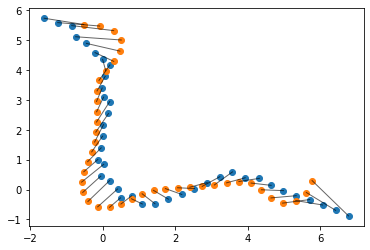

In [ ]:
nodep=MergedNodePositions[:len(MergedNodePositions)//2]
psnodep=MergedNodePositions[len(MergedNodePositions)//2:]


ax = plt.subplot()
plt.scatter(*nodep.T)
plt.scatter(*psnodep.T)
LinkEdges=np.repeat((np.arange(len(MergedNodePositions)//2)[None]),2).reshape((-1,2))
PlotEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((psnodep[PlotEdges[0, j], [0]], nodep[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((psnodep[PlotEdges[0, j], [1]], nodep[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

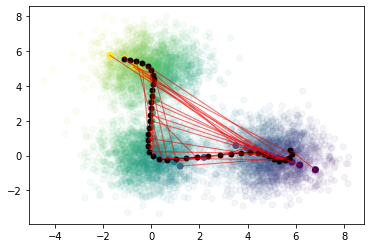

In [ ]:
ax = plt.subplot()
LinkEdges=np.repeat((np.arange(len(NodePositions))[None]),2).reshape((-1,2))
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[np.argsort(branch0)][PlotLinkEdges[0, j], [0]], NewNodePositions2[PlotLinkEdges[1, j], [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[np.argsort(branch0)][PlotLinkEdges[0, j], [1]], NewNodePositions2[PlotLinkEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NewNodePositions2[PlotEdges[0, j], [0]], NewNodePositions2[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NewNodePositions2[PlotEdges[0, j], [1]], NewNodePositions2[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=range(len(PseudotimeNodePositions)))
ax.scatter(*NewNodePositions2.T,c='k',s=24)
plt.show()

## Tree version

### Choices to bin pseudotime nodes

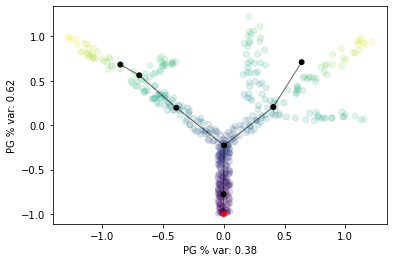

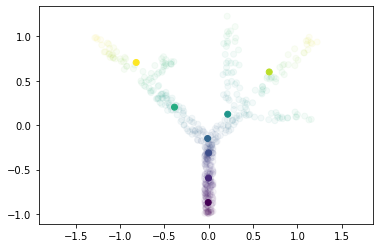

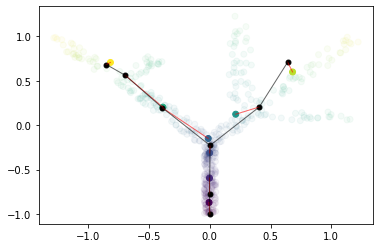

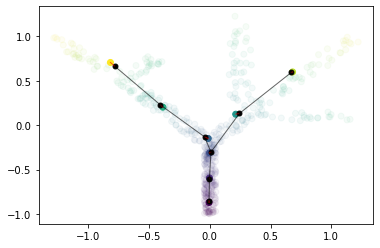

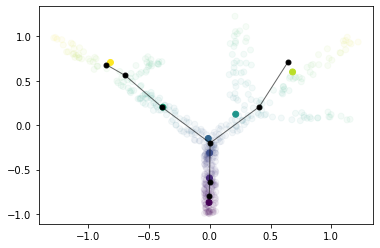

In [ ]:
import networkx as nx
import itertools

#-------generate data
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
X = np.concatenate(([[0,-1]],X))

#-------data labels, pseudotime
pseudotime = X[:,1]+np.abs(X[:,0])

#------compute example elpigraph tree
pg=elpigraph.computeElasticPrincipalTree(X,8,FixNodesAtPoints=[[0]])[0]
NodePositions = pg['NodePositions']
Edges = pg['Edges'][0]  
ElasticMatrix = pg['ElasticMatrix']
#define root node = node with lowest associated mean pseudotime
part, dist = elpigraph.src.core.PartitionData(X,NodePositions,10**8,np.sum(X**2,axis=1,keepdims=1))
root_node = np.argmin([pseudotime[part.flat==n].mean() for n in np.unique(part)])
elpigraph.plot.PlotPG(X,pg,Do_PCA=0,X_color=pseudotime, Node_color=["r" if i==root_node else "k" for i in range(len(NodePositions))])

#-----extract oriented branches and associated data
def bf_search(dict_branches, root_node):
    ''' breadth-first tree search '''
    flat_tree = nx.Graph()
    flat_tree.add_nodes_from(list(set(itertools.chain.from_iterable(dict_branches.keys()))))
    flat_tree.add_edges_from(dict_branches.keys())
    edges = list(nx.bfs_edges(flat_tree, root_node))
    nodes = [root_node] + [v for u, v in edges]
    return edges, nodes

def get_tree(Edges, root_node):
    ##handle edge case: circle or curve topology
    if np.bincount(Edges.flat).max()==2:
        print('WARNING: fitting circle or curve topology')
        branches_single_end = elpigraph.src.supervised.get_circle_or_curve(Edges, root_node)
        return None, None, branches_single_end
    #----get branches
    net=elpigraph.src.graphs.ConstructGraph({'Edges':[Edges]})
    branches=elpigraph.src.graphs.GetSubGraph(net,'branches')
    _dict_branches = {(b[0],b[-1]) : b for i,b in enumerate(branches)} #temporary branch node lists (not in order)
    
    #----check validity of the root node
    root_branch = [k for k in _dict_branches.keys() if root_node in k]
    if len(root_branch)>1: raise ValueError(f'Multiple root branches {root_branch}')
        
    #----reorder branches
    #find ordered relations between branches
    ordered_edges, ordered_nodes = bf_search(_dict_branches,root_node)

    #----create ordered dicts
    dict_tree = {} #branch parent-child relations
    dict_branches = {} #branch node lists
    dict_branches_single_end = {} #branch node lists with no overlapping terminal nodes
    #visited_nodes = []
    for i, e in enumerate(ordered_edges): #for each branch
        #store branch in order (both the key and the list)
        if e not in _dict_branches: dict_branches[e] = _dict_branches[e[::-1]][::-1]
        else: dict_branches[e] = _dict_branches[e]

        #store children 
        dict_tree[e]=[_e for _e in ordered_edges[:i]+ordered_edges[i+1:] if e[-1] in _e]

        #store single ended branch
        if i==0: dict_branches_single_end[e] = dict_branches[e]#if n not in visited_nodes]
        else: dict_branches_single_end[e] = dict_branches[e][1:]
        #dict_branches_single_end[e] = [n for n in dict_branches[e] if n not in visited_nodes]
        #visited_nodes.extend(dict_branches[e])
    return dict_tree, dict_branches, dict_branches_single_end

def get_shortest_paths(Edges, root_node):
    """ Return paths from root node to branches endpoints """
    #---make graph
    net=elpigraph.src.graphs.ConstructGraph({'Edges':[Edges]})
    degrees=net.degree()
    #---check validity of the root node
    if degrees[root_node] > 1: raise ValueError('root node has degree > 1')
    #---get paths
    end_points = [v for v, d in enumerate(degrees) 
                  if d==1 and v != root_node
                 ]
    paths = net.get_shortest_paths(root_node,end_points)
    paths = { (p[0],p[-1]) : p for p in paths }
    return paths
    
def partition_data_by_branch(X, NodePositions, branches):
    partition, dists = elpigraph.src.core.PartitionData(X,NodePositions,10**8,np.sum(X**2,axis=1,keepdims=1))
    branches_dataidx = {k : np.isin(partition[:,0],b) for k,b in branches.items()}
    return branches_dataidx


paths = get_shortest_paths(Edges, root_node)
#tree, branches, branches_single_end = get_tree(Edges, root_node)
paths_dataidx = partition_data_by_branch(X, NodePositions, paths)

#-------pseudotime centroid curve
def nNodes_pseudotime(bX, bpseudotime, bnNodes):
    """"
    Argsorts pseudotime and create nNodes bins 
    with even number of points  but potentially uneven amount of pseudotime
    """
    argsort_pseudotime = np.argsort(bpseudotime)
    PseudotimeNodePositions = np.zeros((bnNodes, bX.shape[1]))
    MeanPseudotime = np.zeros(bnNodes)
    idx_data = np.linspace(0, len(bX), bnNodes + 1, dtype=int)
    for i in range(bnNodes):
        PseudotimeNodePositions[i] = bX[
            argsort_pseudotime[idx_data[i] : idx_data[i + 1]]
        ].mean(axis=0)
        MeanPseudotime[i] = bpseudotime[
            argsort_pseudotime[idx_data[i] : idx_data[i + 1]]
        ].mean()

    return PseudotimeNodePositions, MeanPseudotime

def gen_pseudotime_centroids_4paths(X, pseudotime, paths, paths_dataidx):
    """generate pseudotime centroids for each branch of the graph"""

    #---ignore paths with associated ndatapoints less than nNodes
    nonempty_paths_dataidx = {}
    nonempty_paths = {}
    for (k, bdata), bnodes in zip(
        paths_dataidx.items(), paths.values()
    ):
        if len(np.where(bdata)[0]) >= len(bnodes):
            nonempty_paths_dataidx[k] = bdata
            nonempty_paths[k] = bnodes

    #---generate pseudotime nodes
    nodes_list = list(itertools.chain.from_iterable(nonempty_paths.values()))
            
    nonempty_nNodes = len(set(nodes_list))
    nNodes_bincount = np.bincount(nodes_list)


    PseudotimeNodePositions = np.zeros((nonempty_nNodes, X.shape[1]))
    MeanPseudotime = np.zeros(nonempty_nNodes)

    for (
        k,
        bdata,
    ) in nonempty_paths_dataidx.items():  # for data associated with each branch

        # paths data points, pseudotime, Nodes, nNodes
        bX, bpseudotime = X[bdata], pseudotime[bdata]
        bNodes = nonempty_paths[k]
        bnNodes = len(bNodes)

        # generate paths ps node positions
        _PseudotimeNodePositions, _MeanPseudotime = nNodes_pseudotime(bX, bpseudotime, bnNodes)

        # add them to common array
        PseudotimeNodePositions[bNodes] += _PseudotimeNodePositions
        MeanPseudotime[bNodes] += _MeanPseudotime

    # divide to average nodes that appear in multiple paths
    PseudotimeNodePositions/= nNodes_bincount[:,None]
    MeanPseudotime/= nNodes_bincount
    return PseudotimeNodePositions, MeanPseudotime, nonempty_paths

PseudotimeNodePositions, MeanPseudotime, nonempty_paths = gen_pseudotime_centroids_4paths(X, pseudotime, paths, paths_dataidx)

#------plot
plt.scatter(*X.T,c=pseudotime,alpha=.05)
plt.scatter(*PseudotimeNodePositions.T,c=MeanPseudotime)
plt.axis('equal')
plt.show()

#------for each branch, create elastic edges between pseudotime nodes & elpigraph nodes
#NodesOrder = np.array([n for b in nonempty_paths.values() for n in b])
nPsNodes = len(PseudotimeNodePositions)
LinkEdges = np.array(list(zip( np.arange(nPsNodes), np.arange(nPsNodes)+nPsNodes )))
LinkMu, LinkLambda = 0, .5
LinkMus = np.repeat(LinkMu, nPsNodes)
LinkLambdas = np.repeat(LinkLambda, nPsNodes)

#-----plot matching
ax = plt.subplot()
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NodePositions[PlotEdges[0, j], [0]], NodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NodePositions[PlotEdges[0, j], [1]], NodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=MeanPseudotime)
ax.scatter(*NodePositions.T,c='k',s=24)
plt.show()

#-----merge pseudotime and elpigraph nodesp, elasticmatrix

def augment_graph_paths(NodePositions, Edges, PseudotimeNodePositions, nonempty_paths, Mus, Lambdas, LinkMu, LinkLambda):
    '''
    generate a graph merging node positions and pseudotime node positions
    with one edge between each of their nodes. 
    pseudotime node positions and edges are placed as the top rows of the matrices
    '''
    #------for each branch, create elastic edges between pseudotime nodes & elpigraph nodes
    #ordering of nodespositions in the graph (corresponding to pseudotime nodes)
    nPsNodes = len(PseudotimeNodePositions)
    #link pseudotime nodes and graph nodes
    LinkEdges = np.array(list(zip( np.arange(nPsNodes), np.arange(nPsNodes)+nPsNodes )))
    LinkMus = np.repeat(LinkMu, nPsNodes)
    LinkLambdas = np.repeat(LinkLambda, nPsNodes)
    
    #-----merge pseudotime and graph nodepositions, elasticmatrix
    MergedNodePositions = np.concatenate((PseudotimeNodePositions,NodePositions))
    MergedEdges   = np.concatenate((LinkEdges,Edges+nPsNodes))
    MergedLambdas = np.concatenate((LinkLambdas,Lambdas))
    MergedMus     = np.concatenate((LinkMus,Mus))
    MergedElasticMatrix = elpigraph.src.core.Encode2ElasticMatrix(MergedEdges, MergedLambdas, MergedMus)

    return MergedNodePositions, MergedElasticMatrix, MergedEdges, MergedLambdas, MergedMus

Edges, Lambdas, Mus = elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)
MergedNodePositions, MergedElasticMatrix, MergedEdges, MergedLambdas, MergedMus = augment_graph_paths(NodePositions, Edges, PseudotimeNodePositions, 
                                                                                                       nonempty_paths, Mus, Lambdas, LinkMu, LinkLambda)


(NewNodePositions, ElasticEnergy, 
 partition, dists, 
 MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, MergedNodePositions, MergedElasticMatrix, 
                                                                FixNodesAtPoints=[[] for i in range(len(PseudotimeNodePositions))])
NewNodePositions=NewNodePositions[len(PseudotimeNodePositions):]

(NewNodePositions2, ElasticEnergy, 
 partition, dists, 
 MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment_v2(X, NodePositions, ElasticMatrix, FixNodesAtPoints=[],
                                                                PseudotimeNodePositions=PseudotimeNodePositions)

#-----plot update
ax = plt.subplot()
PlotLinkEdges = LinkEdges.T#-np.min(LinkEdges[:,0])
for j in range(PlotLinkEdges.shape[1]):
    x_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [0]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [0]]))
    y_coo = np.concatenate((PseudotimeNodePositions[PlotLinkEdges[0, j], [1]], NewNodePositions[PlotLinkEdges[1, j]-len(PseudotimeNodePositions), [1]]))
    ax.plot(x_coo, y_coo, c='r', linewidth=1, alpha=0.6)
    #ax.scatter(x_coo, y_coo, c=['b','r'], linewidth=1, alpha=0.6)
PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=MeanPseudotime)
ax.scatter(*NewNodePositions.T,c='k',s=24)
plt.show()

#---------compare without update
ax = plt.subplot()

(NewNodePositions, ElasticEnergy, 
 partition, dists, 
 MSE, EP, RP )= elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, NodePositions, ElasticMatrix,FixNodesAtPoints=[])

PlotEdges=Edges.T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [0]], NewNodePositions[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((NewNodePositions[PlotEdges[0, j], [1]], NewNodePositions[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="black", linewidth=1, alpha=0.6)

ax.scatter(*X.T,c=pseudotime,alpha=.05)
ax.scatter(*PseudotimeNodePositions.T,c=MeanPseudotime)
ax.scatter(*NewNodePositions.T,c='k',s=24)
plt.show()

In [ ]:
%pdb

Automatic pdb calling has been turned ON


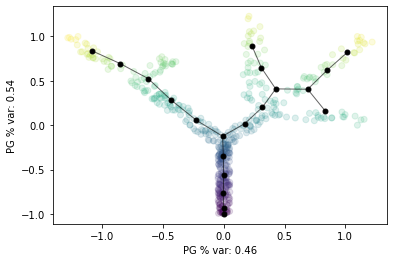

In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import elpigraph
import sys
sys.path.insert(0,'../../STREAM2/notebooks/')
import elpigraph_v2

#-------generate data, data labels, pseudotime
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
X = np.concatenate(([[0,-1],[.2,1.2],[-1.2,1],[1.1,0],[1.1,1]],X))
pseudotime = np.array([np.linalg.norm(X[0]-x) for x in X])
root_node=0
#pg=elpigraph.computeElasticPrincipalTree(X,40)[0]
spg=elpigraph.computeElasticPrincipalTree(X,20,pseudotime=pseudotime,FixNodesAtPoints=[[0]],StoreGraphEvolution=True)[0]
#elpigraph.plot.PlotPG(X,pg,Do_PCA=0,X_color=pseudotime)
elpigraph.plot.PlotPG(X,spg,Do_PCA=0,X_color=pseudotime)

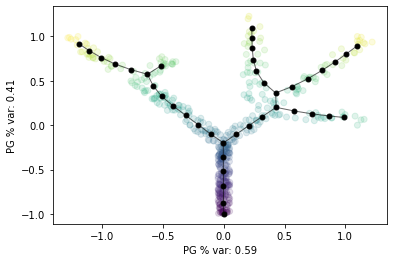

In [ ]:
spg=elpigraph.computeElasticPrincipalTree(X,40,pseudotime=pseudotime,FixNodesAtPoints=[[0]],StoreGraphEvolution=True,pseudotimeLambda=10)[0]
elpigraph.plot.PlotPG(X,spg,Do_PCA=0,X_color=pseudotime)

/home/jo/anaconda3/envs/wip/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


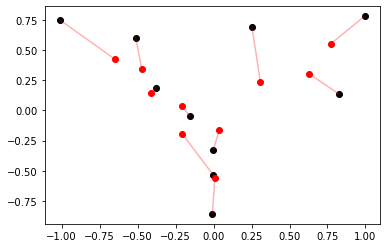

In [ ]:
nodep=spg['AllMergedNodePositions'][10][:10]
pnodep=spg['AllMergedNodePositions'][10][10:]
plt.scatter(*nodep.T,c='k')
plt.scatter(*pnodep.T,c='r')

ax=plt.subplot()
PlotEdges=np.repeat((np.arange(len(nodep))[None]),2).reshape((-1,2)).T
# plot edges
for j in range(PlotEdges.shape[1]):
    x_coo = np.concatenate((nodep[PlotEdges[0, j], [0]], pnodep[PlotEdges[1, j], [0]]))
    y_coo = np.concatenate((nodep[PlotEdges[0, j], [1]], pnodep[PlotEdges[1, j], [1]]))
    ax.plot(x_coo, y_coo, c="r", alpha=0.3)

In [8]:
%load_ext line_profiler

In [766]:
pg1=elpigraph.computeElasticPrincipalTree(X,30)[0]
pg2=elpigraph.computeElasticPrincipalTree(X,30,FixNodesAtPoints=[[0]])[0]
pg3=elpigraph.computeElasticPrincipalTree(X,30,FixNodesAtPoints=[[0]],pseudotime=pseudotime,pseudotimeLambda=10)[0]

import pickle
with open('epg.pkl','wb') as f:
    pickle.dump([pg1,pg2,pg3],f)

NameError: name 'pickle' is not defined

In [302]:
%time pg=elpigraph.computeElasticPrincipalTree(X,30)[0]
%time pg=elpigraph.computeElasticPrincipalTree(X,30,FixNodesAtPoints=[[0]])[0]
%time pg=elpigraph.computeElasticPrincipalTree(X,30,FixNodesAtPoints=[[0]],pseudotime=pseudotime,pseudotimeLambda=10)[0]

ERROR! Session/line number was not unique in database. History logging moved to new session 5239
CPU times: user 22.9 s, sys: 18.5 s, total: 41.4 s
Wall time: 3.88 s
CPU times: user 24.6 s, sys: 19.6 s, total: 44.1 s
Wall time: 4.3 s
CPU times: user 2min 10s, sys: 1min 47s, total: 3min 58s
Wall time: 22.2 s


In [93]:
Edges,Lambdas,Mus=elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)

In [95]:
pg=elpigraph.computeElasticPrincipalTree(X,30,FixNodesAtPoints=[[0]],pseudotime=pseudotime,pseudotimeLambda=10)[0]
NodePositions, ElasticMatrix = pg['NodePositions'], pg['ElasticMatrix']

In [23]:
%lprun -f elpigraph.src.supervised.gen_pseudotime_augmented_graph_by_path MeanPseudotime, MergedNodePositions, MergedElasticMatrix, MergedEdges, nPseudoNodes = elpigraph.src.supervised.gen_pseudotime_augmented_graph_by_path(X, np.sum(X**2,axis=1,keepdims=1), NodePositions, ElasticMatrix, pseudotime, root_node, LinkMu, LinkLambda,PointWeights=np.ones_like(part))

Timer unit: 1e-06 s

Total time: 0.006807 s
File: /mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/src/supervised.py
Function: gen_pseudotime_augmented_graph_by_path at line 642

Line #      Hits         Time  Per Hit   % Time  Line Contents
   642                                           def gen_pseudotime_augmented_graph_by_path(
   643                                               X,
   644                                               SquaredX,
   645                                               NodePositions,
   646                                               ElasticMatrix,
   647                                               pseudotime,
   648                                               root_node,
   649                                               LinkMu,
   650                                               LinkLambda,
   651                                               PointWeights,
   652                                               TrimmingRadius=float("

In [26]:
%lprun -f elpigraph.src.core.PrimitiveElasticGraphEmbedment_v2 NewNodePositions, ElasticEnergy, partition, dists, MSE, EP, RP = elpigraph.src.core.PrimitiveElasticGraphEmbedment_v2(X, MergedNodePositions, MergedElasticMatrix, FixNodesAtPoints=[[root_node]])

Timer unit: 1e-06 s

Total time: 0.00468 s
File: /mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/src/core.py
Function: PrimitiveElasticGraphEmbedment_v2 at line 1106

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1106                                           def PrimitiveElasticGraphEmbedment_v2(
  1107                                               X,
  1108                                               NodePositions,
  1109                                               ElasticMatrix,
  1110                                               MaxNumberOfIterations=10,
  1111                                               eps=0.01,
  1112                                               Mode=1,
  1113                                               FinalEnergy="Base",
  1114                                               alpha=0,
  1115                                               beta=0,
  1116                                               prob=1,
  1117          

In [19]:
%lprun -f elpigraph.src.core.PrimitiveElasticGraphEmbedment NewNodePositions, ElasticEnergy, partition, dists, MSE, EP, RP = elpigraph.src.core.PrimitiveElasticGraphEmbedment(X, MergedNodePositions, MergedElasticMatrix)

Timer unit: 1e-06 s

Total time: 0.027008 s
File: /mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/src/core.py
Function: PrimitiveElasticGraphEmbedment at line 672

Line #      Hits         Time  Per Hit   % Time  Line Contents
   672                                           def PrimitiveElasticGraphEmbedment(
   673                                               X,
   674                                               NodePositions,
   675                                               ElasticMatrix,
   676                                               MaxNumberOfIterations=10,
   677                                               eps=0.01,
   678                                               Mode=1,
   679                                               FinalEnergy="Base",
   680                                               alpha=0,
   681                                               beta=0,
   682                                               prob=1,
   683                

In [21]:
import itertools
# ---generate pseudotime nodes
nodes_list = list(itertools.chain.from_iterable(paths.values()))

nNodes = len(NodePositions)
nNodes_bincount = np.bincount(nodes_list)

PseudotimeNodePositions = np.zeros((nNodes, X.shape[1]))
MeanPseudotime = np.zeros(nNodes)

for (
    k,
    bdata,
) in paths_dataidx.items():  # for data associated with each branch

    # paths data points, pseudotime, Nodes, nNodes
    bX, bpseudotime, bweights = X[bdata], pseudotime[bdata], PointWeights[bdata]
    bNodes = paths[k]
    bnNodes = len(bNodes)

    if len(np.where(bdata)[0]) <= bnNodes:
        # ignore paths with associated ndatapoints less than nNodes
        PseudotimeNodePositions[bNodes] += NodePositions[bNodes]
    else:
        # generate paths ps node positions
        (
            _PseudotimeNodePositions,
            _MeanPseudotime,
            bX_chunks,
        ) = elpigraph.src.supervised.nNodes_pseudotime_weighted_nb(bX, bpseudotime, bnNodes, bweights)
        if np.any(np.array([len(b) for b in bX_chunks]) < 2):
            # generate paths ps node positions
            (
                _PseudotimeNodePositions,
                _MeanPseudotime,
                bX_chunks,
            ) = elpigraph.src.supervised.nNodes_pseudotime_even_nb(
                bX,
                bpseudotime,
                bnNodes,
            )

        _PseudotimeNodePositions = np.vstack(
            [
                bX_chunks[i][elpigraph.src.supervised.vq(_PseudotimeNodePositions[[i]], bX_chunks[i])[0][0]]
                for i in range(bnNodes)
            ]
        )
        _PseudotimeNodePositions = elpigraph.src.supervised.interp_bins_nb(_PseudotimeNodePositions)

        # add them to common array
        PseudotimeNodePositions[bNodes] += _PseudotimeNodePositions
        MeanPseudotime[bNodes] += _MeanPseudotime

# divide to average nodes that appear in multiple paths
PseudotimeNodePositions /= nNodes_bincount[:, None]
MeanPseudotime /= nNodes_bincount

In [39]:
#-------generate data, data labels, pseudotime
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
pseudotime = X[:,1]+np.abs(X[:,0])

#------compute example elpigraph tree
pg=elpigraph.computeElasticPrincipalTree(X,11)[0]
NodePositions, ElasticMatrix = pg['NodePositions'], pg['ElasticMatrix']
Edges, Lambdas, Mus = elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)

#------define parameters: root node (node with lowest associated mean pseudotime) and pseudotime edges lambdas, Mus
LinkMu, LinkLambda = 0, .5
part, dist = elpigraph.src.core.PartitionData(X,NodePositions,10**8,np.sum(X**2,axis=1,keepdims=1))
root_node = np.argmin([pseudotime[part.flat==n].mean() for n in np.unique(part)])

#------generate merged graph
MeanPseudotime, MergedNodePositions, MergedElasticMatrix, MergedEdges, nPseudoNodes = elpigraph.src.supervised.gen_pseudotime_augmented_graph_by_path(X, np.sum(X**2,axis=1,keepdims=1), NodePositions, ElasticMatrix, pseudotime, root_node, LinkMu, LinkLambda,PointWeights=np.ones_like(part))

#------fit the graph
NewNodePositions, ElasticEnergy, partition, dists, MSE, EP, RP = elpigraph.src.core.PrimitiveElasticGraphEmbedment_v2(X, MergedNodePositions, MergedElasticMatrix, FixNodesAtPoints=[[] for i in range(nPseudoNodes)])
NewNodePositions=NewNodePositions[nPseudoNodes:]

elpigraph.plot.PlotPG(X,pg,Do_PCA=0,X_color=pseudotime, Node_color=["r" if i==root_node else "k" for i in range(len(NodePositions))])
elpigraph.plot.PlotPG(X,{'NodePositions':MergedNodePositions,'Edges':[MergedEdges]},Do_PCA=0,
                      X_color=pseudotime, Node_color=["r" if i<nPseudoNodes else "k" for i in range(len(MergedNodePositions))])
elpigraph.plot.PlotPG(X,{'NodePositions':NewNodePositions,'Edges':[Edges]},Do_PCA=0,X_color=pseudotime)

TypeError: 'NoneType' object is not subscriptable

In [17]:
def RemoveNode(NodePositions, ElasticMatrix, AdjustVect, FixNodesAtPoints):
    """
    ##  This grammar operation removes a leaf node (connectivity==1)
    """
    Lambda = ElasticMatrix.copy()
    np.fill_diagonal(Lambda, 0)
    Connectivities = (Lambda > 0).sum(axis=0)

    # Define sizes
    nNodes = ElasticMatrix.shape[0]
    if FixNodesAtPoints != []:
        nGraphs = (Connectivities == 1).sum() - len(FixNodesAtPoints)
        start = len(FixNodesAtPoints)
    else:
        nGraphs = (Connectivities == 1).sum()
        start = 0

    # Preallocate arrays
    NodePositionsArray = [
        np.zeros((nNodes - 1, NodePositions.shape[1])) for i in range(nGraphs)
    ]
    ElasticMatrices = [np.zeros((nNodes - 1, nNodes - 1)) for i in range(nGraphs)]
    NodeIndicesArray = np.zeros((nNodes - 1, nGraphs), dtype=int)
    AdjustVectArray = [[] for i in range(nGraphs)]

    k = 0
    for i in range(start, Connectivities.shape[0]):
        if Connectivities[i] == 1:
            # if terminal node remove it
            newInds = np.concatenate(
                (np.arange(0, i, dtype=int), np.arange(i + 1, nNodes, dtype=int))
            )
            AdjustVectArray[k] = [AdjustVect[j] for j in newInds]
            NodePositionsArray[k] = NodePositions[newInds, :]
            tmp = np.repeat(False, nNodes)
            tmp[newInds] = True
            tmp2 = ElasticMatrix[tmp, :]
            ElasticMatrices[k] = tmp2[:, tmp]
            NodeIndicesArray[:, k] = newInds
            k += 1
    return NodePositionsArray, ElasticMatrices, AdjustVectArray, NodeIndicesArray


def BisectEdge(
    NodePositions,
    ElasticMatrix,
    AdjustVect,
    Min_K=1,
    MaxNumberOfGraphCandidates=float("inf"),
):
    """
    # % This grammar operation inserts a node inside the middle of each edge
    # % The elasticity of the edges do not change
    # % The elasticity of the newborn star is chosen as
    # % mean over the neighbour stars if the edge connects two star centers
    # % or
    # % the one of the single neigbour star if this is a dangling edge
    # % or
    # % if one starts from a single edge, the star elasticities should be on
    # % one of two elements in the diagoal of the ElasticMatrix
    """
    # Decompose Elastic Matrix: Mus
    Mus = ElasticMatrix.diagonal()
    # Get list of edges
    Edges, _, _ = DecodeElasticMatrix2(ElasticMatrix)

    # Define some constants
    nNodes = NodePositions.shape[0]
    if Min_K > 1:
        Degree = np.bincount(Edges.flatten())
        EdgDegree = np.max(Degree[Edges], axis=1)
        nGraphs = np.where(EdgDegree >= Min_K)[0]
    else:
        nGraphs = np.array(range(Edges.shape[0]))

    # In case we have limits on the number of candidates
    if MaxNumberOfGraphCandidates < len(nGraphs):
        edge_lengths = np.sum(
            (NodePositions[Edges[:, 0], :] - NodePositions[Edges[:, 1], :]).T ** 2,
            axis=0,
        )
        inds = np.argsort(edge_lengths)[::-1]
        if Min_K > 1:
            nGraphs = inds[np.isin(inds, nGraphs)][:MaxNumberOfGraphCandidates]
            Edges = Edges[nGraphs]
        else:
            nGraphs = nGraphs[:MaxNumberOfGraphCandidates]
            Edges = Edges[inds[nGraphs]]

    # Create prototypes for new NodePositions, ElasticMatrix and inds
    npProt = np.vstack((NodePositions, np.zeros((1, NodePositions.shape[1]))))
    emProt = np.vstack(
        (np.hstack((ElasticMatrix, np.zeros((nNodes, 1)))), np.zeros((1, nNodes + 1)))
    )
    niProt = np.arange(nNodes + 1)
    # niProt[nNodes] = 0

    # Allocate arrays and put prototypes in place
    NodePositionsArray = [npProt.copy() for i in range(len(nGraphs))]
    ElasticMatrices = [emProt.copy() for i in range(len(nGraphs))]
    NodeIndicesArray = np.repeat(niProt[:, np.newaxis], len(nGraphs), axis=1)
    AdjustVectArray = [AdjustVect + [False] for i in range(len(nGraphs))]

    for j, i in enumerate(nGraphs):
        NewNodePosition = (
            NodePositions[
                Edges[i, 0],
            ]
            + NodePositions[
                Edges[i, 1],
            ]
        ) / 2

        # Fill NodePosition
        NodePositionsArray[j][nNodes, :] = NewNodePosition
        # correct elastic matrix
        Lambda = ElasticMatrix[Edges[i, 0], Edges[i, 1]]
        # remove edge
        ElasticMatrices[j][Edges[i, 0], Edges[i, 1]] = 0
        ElasticMatrices[j][Edges[i, 1], Edges[i, 0]] = 0
        # add 2 edges
        ElasticMatrices[j][Edges[i, 0], nNodes] = Lambda
        ElasticMatrices[j][nNodes, Edges[i, 0]] = Lambda
        ElasticMatrices[j][nNodes, Edges[i, 1]] = Lambda
        ElasticMatrices[j][Edges[i, 1], nNodes] = Lambda
        # Define mus of edges
        mu1 = Mus[Edges[i, 0]]
        mu2 = Mus[Edges[i, 1]]
        if mu1 > 0 and mu2 > 0:
            ElasticMatrices[j][nNodes, nNodes] = (mu1 + mu2) / 2
        else:
            ElasticMatrices[j][nNodes, nNodes] = max(mu1, mu2)

    return NodePositionsArray, ElasticMatrices, AdjustVectArray, NodeIndicesArray


def AddNode2Node(
    X,
    NodePositions,
    ElasticMatrix,
    partition,
    AdjustVect,
    FixNodesAtPoints,
    Max_K=float("inf"),
    MaxNumberOfGraphCandidates=float("inf"),
):
    """
    #' Adds a node to each graph node
    #'
    #' This grammar operation adds a node to each graph node. The position of the node
    #' is chosen as a linear extrapolation for a leaf node (in this case the elasticity of
    #' a newborn star is chosed as in BisectEdge operation), or as the data point giving
    #' the minimum local MSE for a star (without any optimization).
    #'
    #' @param X
    #' @param NodePositions
    #' @param ElasticMatrix
    #' @return
    #' @export
    #'
    #' @details
    #'
    #'
    #'
    #' @examples
    """
    nNodes = NodePositions.shape[0]
    Mus = ElasticMatrix.diagonal()
    Lambda = ElasticMatrix.copy()
    np.fill_diagonal(Lambda, 0)
    indL = Lambda > 0
    Connectivities = indL.sum(axis=0)
    # add pointweights here if added
    assoc = np.bincount(partition[partition > -1].ravel(), minlength=nNodes)
    # Create prototypes for new NodePositions, ElasticMatrix and inds
    npProt = np.vstack((NodePositions, np.zeros((1, NodePositions.shape[1]))))
    emProt = np.vstack(
        (np.hstack((Lambda, np.zeros((nNodes, 1)))), np.zeros((1, nNodes + 1)))
    )
    niProt = np.arange(nNodes + 1, dtype=int)
    #     niProt[nNodes] = 0

    MuProt = np.zeros(nNodes + 1)
    MuProt[:-1] = Mus

    if not np.isinf(Max_K):
        Degree = np.sum(ElasticMatrix > 0, axis=1)
        Degree[Degree > 1] = Degree[Degree > 1] - 1

        if np.sum(Degree <= Max_K) > 1:
            idx_nodes = np.where(Degree <= Max_K)[0]
        else:
            raise ValueError("AddNode2Node impossible with the current parameters!")
    else:
        idx_nodes = np.array(range(nNodes))

    # In case we have limits on the number of candidates
    if MaxNumberOfGraphCandidates < len(idx_nodes) and np.isinf(Max_K):
        idx_nodes = np.argsort(assoc)[::-1][:MaxNumberOfGraphCandidates]

    elif MaxNumberOfGraphCandidates < len(idx_nodes) and not (np.isinf(Max_K)):
        nGraphs = [i for i in np.argsort(assoc)[::-1] if i in idx_nodes]
        idx_nodes = np.array(nGraphs)[:MaxNumberOfGraphCandidates]

    # In case we have fixed nodes
    if FixNodesAtPoints != []:
        idx_nodes = idx_nodes[~np.isin(idx_nodes, np.arange(len(FixNodesAtPoints)))]

    # Put prototypes to corresponding places
    NodePositionsArray = [npProt.copy() for i in range(len(idx_nodes))]
    ElasticMatrices = [emProt.copy() for i in range(len(idx_nodes))]
    NodeIndicesArray = np.repeat(niProt[:, np.newaxis], len(idx_nodes), axis=1)
    AdjustVectArray = [AdjustVect + [False] for i in range(len(idx_nodes))]

    for j, i in enumerate(idx_nodes):
        MuProt[-1] = 0
        # Compute mean edge elasticity for edges with node i
        meanL = Lambda[
            i,
            indL[
                i,
            ],
        ].mean(axis=0)
        # Add edge to elasticity matrix
        ElasticMatrices[j][nNodes, i] = ElasticMatrices[j][i, nNodes] = meanL

        if Connectivities[i] == 1:
            # Add node to terminal node
            ineighbour = np.nonzero(
                indL[
                    i,
                ]
            )[0]
            # Calculate new node position
            NewNodePosition = (
                2
                * NodePositions[
                    i,
                ]
                - NodePositions[
                    ineighbour,
                ]
            )
            # Complete Elasticity Matrix
            MuProt[nNodes] = Mus[ineighbour]
        else:
            # Add node to a star
            # if 0 data points associated with this star
            if assoc[i] == 0:
                # then select mean of all leaves as new position
                NewNodePosition = NodePositions[indL[:, i]].mean(axis=0)

            else:
                # Otherwise take the mean of the points associated with the
                # central node
                NewNodePosition = X[(partition == i).ravel()].mean(axis=0)
        # fill node position
        NodePositionsArray[j][nNodes, :] = NewNodePosition
        np.fill_diagonal(ElasticMatrices[j], MuProt)

    return NodePositionsArray, ElasticMatrices, AdjustVectArray, NodeIndicesArray


def ShrinkEdge(
    NodePositions,
    ElasticMatrix,
    AdjustVect,
    Min_K=1,
    MaxNumberOfGraphCandidates=float("inf"),
):
    """
    # %
    # % This grammar operation removes an edge from the graph
    # % If this is an edge connecting a leaf node then it is equivalent to
    # % RemoveNode. So we remove only internal edges.
    # % If this is an edge connecting two stars then their leaves are merged,
    # % and the star is placed in the middle of the shrinked edge.
    # % The elasticity of the new formed star is the average of two star
    # % elasticities.
    # %
    """
    ## Shrink edge
    Mus = ElasticMatrix.diagonal()
    Lambda = ElasticMatrix.copy()
    np.fill_diagonal(Lambda, 0)
    Connectivities = (Lambda > 0).sum(axis=0)
    # get list of edges
    start, stop = np.triu(ElasticMatrix, 1).nonzero()
    # Edges = np.concatenate((start[None], stop[None]))
    # define size
    nNodes = NodePositions.shape[0]
    # identify edges with minimal connectivity > 1
    Degree = np.hstack((Connectivities[start[None].T], Connectivities[stop[None].T]))

    ind_sup1 = np.min(Degree, axis=1) > 1
    ind_min_K = np.max(Degree, axis=1) >= Min_K
    ind = np.where(ind_sup1 & ind_min_K)[0]

    # calculate nb of graphs
    nGraphs = len(ind)

    # In case we have limits on the number of candidates
    if MaxNumberOfGraphCandidates < nGraphs:
        edge_lengths = np.sum(
            (NodePositions[start, :] - NodePositions[stop, :]).T ** 2,
            axis=0,
        )
        nGraphs = MaxNumberOfGraphCandidates
        ind_l = np.argsort(edge_lengths)
        ind_l = ind_l[np.isin(ind_l, ind)][:nGraphs]
        start, stop = start[ind_l], stop[ind_l]
    else:
        start, stop = start[ind], stop[ind]

    # preallocate array
    NodePositionsArray = [
        np.zeros((nNodes - 1, NodePositions.shape[1])) for i in range(nGraphs)
    ]
    ElasticMatrices = [np.zeros((nNodes - 1, nNodes - 1)) for i in range(nGraphs)]
    NodeIndicesArray = np.zeros((nNodes - 1, nGraphs), dtype=int)
    AdjustVectArray = [[] for i in range(nGraphs)]

    for i in range(nGraphs):
        # create copy of elastic matrix
        em = ElasticMatrix.copy()
        # Reattaches all edges connected with stop[i] to start[i]
        # and make a new star with an elasticity average of two merged stars
        em[start[i],] = np.maximum(
            Lambda[
                start[i],
            ],
            Lambda[
                stop[i],
            ],
        )
        em[:, start[i]] = np.maximum(Lambda[:, start[i]], Lambda[:, stop[i]])
        em[start[i], start[i]] = (Mus[start[i]] + Mus[stop[i]]) / 2
        #         em[start[i], start[i]] = Mus[start[i]] + Mus[stop[i]] / 2  #### R bug ????
        # Create copy of node positions
        nodep = NodePositions.copy()
        # modify node start[i]
        nodep[start[i], :] = (nodep[start[i], :] + nodep[stop[i], :]) / 2
        # Form index for retained nodes and extract corresponding part of
        # node positions and elastic matrix
        newInds = np.concatenate(
            (np.arange(0, stop[i]), np.arange(stop[i] + 1, nNodes))
        )

        AdjustVectArray[i] = [AdjustVect[j] for j in newInds]

        NodePositionsArray[i] = nodep[newInds, :]
        ElasticMatrices[i] = em.take(newInds, axis=0).take(newInds, axis=1)
        NodeIndicesArray[:, i] = newInds

    return NodePositionsArray, ElasticMatrices, AdjustVectArray, NodeIndicesArray



In [53]:
#-------generate data, data labels, pseudotime
X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
pseudotime = X[:,1]+np.abs(X[:,0])
PointWeights=np.ones_like(pseudotime)[:,None]
TrimmingRadius=np.inf
SquaredX=np.sum(X**2,axis=1,keepdims=1)
pseudotimeLambda = .5
FixNodesAtPoints=[[root_node]]
root_node=np.argmin(pseudotime)

#------compute example elpigraph tree
pg=elpigraph.computeElasticPrincipalTree(X,31)[0]
NodePositions, ElasticMatrix = pg['NodePositions'], pg['ElasticMatrix']
Edges, Lambdas, Mus = elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)

#------define parameters: root node (node with lowest associated mean pseudotime) and pseudotime edges lambdas, Mus
part, dist, precomp_d = elpigraph.src.core.PartitionData(X,NodePositions,10**8,np.sum(X**2,axis=1,keepdims=1),precomp=True)
pg=elpigraph.computeElasticPrincipalTree(X,31,FixNodesAtPoints=FixNodesAtPoints)[0]
NodePositions, ElasticMatrix = pg['NodePositions'], pg['ElasticMatrix']
Edges, Lambdas, Mus = elpigraph.src.core.DecodeElasticMatrix(ElasticMatrix)

#------define parameters: root node (node with lowest associated mean pseudotime) and pseudotime edges lambdas, Mus

part, dist, precomp_d = elpigraph.src.core.PartitionData(X,NodePositions,10**8,SquaredX,precomp=True)
#------generate merged graph
(
    MeanPseudotime,
    MergedNodePositions,
    MergedElasticMatrix,
    MergedEdges,
    nPseudoNodes,
) = elpigraph.src.supervised.old_gen_pseudotime_augmented_graph_by_path(X,SquaredX,NodePositions,ElasticMatrix,pseudotime,
                                                                    root_node=0,LinkMu=0,LinkLambda=pseudotimeLambda,
                                                                    PointWeights=PointWeights,TrimmingRadius=TrimmingRadius,
                                                                    partition=part,)     

(
    MergedNodePositions2,
    MergedElasticMatrix,
    MergedEdges2,
    nPseudoNodes,
    cache
) = elpigraph.src.supervised.gen_pseudotime_augmented_graph_by_path(X,SquaredX,NodePositions,ElasticMatrix,pseudotime,
                                                                    root_node=0,LinkMu=0,LinkLambda=pseudotimeLambda,
                                                                    PointWeights=PointWeights,TrimmingRadius=TrimmingRadius,
                                                                    partition=part,)     

In [66]:
(
    MergedNodePositions2,
    MergedElasticMatrix,
    MergedEdges2,
    nPseudoNodes,
    cache
) = gen_pseudotime_augmented_graph_by_path(X,SquaredX,NodePositions,ElasticMatrix,pseudotime,
                                                                    root_node=0,LinkMu=0,LinkLambda=pseudotimeLambda,
                                                                    PointWeights=PointWeights,TrimmingRadius=TrimmingRadius,
                                                                    partition=part,)    

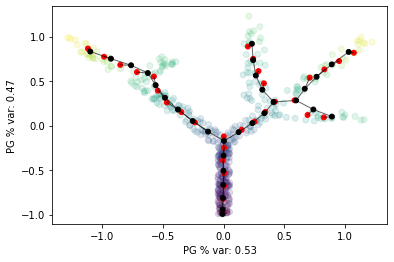

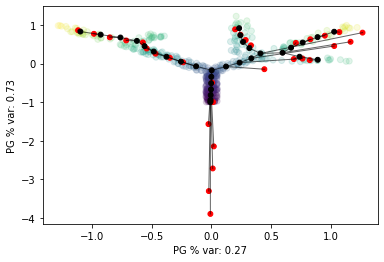

In [67]:
elpigraph.plot.PlotPG(X,{'NodePositions':MergedNodePositions,'Edges':[MergedEdges]},Do_PCA=0,
                      X_color=pseudotime, Node_color=["r" if i<nPseudoNodes else "k" for i in range(len(MergedNodePositions))])
elpigraph.plot.PlotPG(X,{'NodePositions':MergedNodePositions2,'Edges':[MergedEdges]},Do_PCA=0,
                      X_color=pseudotime, Node_color=["r" if i<nPseudoNodes else "k" for i in range(len(MergedNodePositions))])

In [24]:
partition=part
# ------extract oriented paths and associated data
Edges, Lambdas, Mus = elpigraph.src.supervised.DecodeElasticMatrix(ElasticMatrix)

paths = elpigraph.src.supervised.get_shortest_paths(Edges, root_node)
if partition is None:
    paths_dataidx = elpigraph.src.supervised.partition_data_by_branch(
        X, SquaredX, NodePositions, paths, TrimmingRadius
    )
else:
    paths_dataidx = elpigraph.src.supervised.partition_data_by_branch_precomp(partition, paths)

# ------generate pseudotime centroid branches
(PseudotimeNodePositions,nonempty_paths,cache_PseudotimeNodePositions
) = elpigraph.src.supervised.gen_pseudotime_centroids_by_path(
    X, NodePositions, pseudotime, paths, paths_dataidx, PointWeights
)
(PseudotimeNodePositions2,nonempty_paths,_
) = elpigraph.src.supervised.old_gen_pseudotime_centroids_by_path(
    X, NodePositions, pseudotime, paths, paths_dataidx, PointWeights
)

# ------for each branch, create elastic edges between pseudotime nodes & elpigraph nodes and merge pseudotime and elpigraph nodesp, elasticmatrix
(MergedNodePositions,MergedElasticMatrix,MergedEdges,MergedLambdas,MergedMus,
) = elpigraph.src.supervised.augment_graph_by_path(NodePositions,Edges,PseudotimeNodePositions,Mus,Lambdas,LinkMu=0,LinkLambda=pseudotimeLambda,
)

In [441]:
AdjustVect=[False]*len(X)
MaxNumberOfGraphCandidatesDict=MaxNumberOfGraphCandidatesDict={'AddNode2Node': np.inf, 'BisectEdge': np.inf, 'RemoveNode': np.inf, 'ShrinkEdge': np.inf}
opTypes=np.array(["bisectedge", "addnode2node","removenode","shrinkedge"])
MaxBlockSize=1000000
SquaredX=np.sum(X**2,axis=1,keepdims=1)
TrimmingRadius=np.inf
verbose=1

NodePositionsArrayAll = []
ElasticMatricesAll = []
AdjustVectAll = []
NodeIndicesArrayAll = []
opTypesAll = []
newpartitionsAll = []
newprecomp_dAll = []
newpathsAll = []
newpartdiffsAll = []
newpathsdataidx_All = []

partition, dists, precomp_d = elpigraph.src.core.PartitionData(
        X,
        NodePositions,
        MaxBlockSize,
        SquaredX,
        TrimmingRadius,
        precomp=True,
    )

for i in range(len(opTypes)):
    if verbose:
        print(" Operation type : ", opTypes[i])
    (
        NodePositionsArray,
        ElasticMatrices,
        AdjustVectArray,
        NodeIndicesArray,
    ) = elpigraph.src.grammar_operations.GraphGrammarOperation(
        X,
        NodePositions,
        ElasticMatrix,
        AdjustVect,
        opTypes[i],
        partition,
        FixNodesAtPoints,
        MaxNumberOfGraphCandidatesDict,
    )

    NodePositionsArrayAll.extend(NodePositionsArray)
    ElasticMatricesAll.extend(ElasticMatrices)
    AdjustVectAll.extend(AdjustVectArray)
    NodeIndicesArrayAll.extend(NodeIndicesArray.T)
    opTypesAll.extend([opTypes[i]] * len(NodePositionsArray))
    


 Operation type :  bisectedge
 Operation type :  addnode2node
 Operation type :  removenode
 Operation type :  shrinkedge


In [384]:
cache_PseudotimeNodePositions_=cache_PseudotimeNodePositions.copy()

In [483]:
cache_PseudotimeNodePositions=cache_PseudotimeNodePositions_.copy()

In [484]:
%%time

print(len(cache_PseudotimeNodePositions))
Valid_configurations = range(len(NodePositionsArrayAll))
cache_PseudotimeNodePositions = {}
for i in Valid_configurations:

    newpartition, newdists, newprecomp_d = elpigraph.src.core.RePartitionData(X,NodePositions,NodePositionsArrayAll[i],NodeIndicesArrayAll[i],
                                                           opTypesAll[i],precomp_d,SquaredX,TrimmingRadius=np.inf,)  
    
    (MergedNodePositions2,MergedElasticMatrix,MergedEdges,nPseudoNodes,cache_PseudotimeNodePositions
    ) = gen_pseudotime_augmented_graph_by_path(X,SquaredX,NodePositionsArrayAll[i],ElasticMatricesAll[i],
                                                                            pseudotime,root_node=0,LinkMu=0,
                                                                            LinkLambda=pseudotimeLambda,PointWeights=PointWeights,
                                                                            TrimmingRadius=TrimmingRadius,partition=newpartition,
                                                                       cache_PseudotimeNodePositions=cache_PseudotimeNodePositions
                                             )
print(len(cache_PseudotimeNodePositions))

9
93
CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 144 ms


In [401]:
%%time
print(len(cache_PseudotimeNodePositions))

Valid_configurations = range(len(NodePositionsArrayAll))
    
for i in Valid_configurations:
    newpartition, newdists, newprecomp_d = elpigraph.src.core.RePartitionData(X,NodePositions,NodePositionsArrayAll[i],NodeIndicesArrayAll[i],
                                                           opTypesAll[i],precomp_d,SquaredX,TrimmingRadius=np.inf,)  
    

    (MeanPseudotime,MergedNodePositions,MergedElasticMatrix,MergedEdges,nPseudoNodes,
    ) = elpigraph.src.supervised.gen_pseudotime_augmented_graph_by_path(X,SquaredX,NodePositionsArrayAll[i],ElasticMatricesAll[i],
                                                                        pseudotime,root_node=0,LinkMu=0,
                                                                        LinkLambda=pseudotimeLambda,PointWeights=PointWeights,
                                                                        TrimmingRadius=TrimmingRadius,partition=newpartition,)
    
    (MergedNodePositions2,MergedElasticMatrix,MergedEdges,nPseudoNodes,cache_PseudotimeNodePositions
    ) = gen_pseudotime_augmented_graph_by_path(X,SquaredX,NodePositionsArrayAll[i],ElasticMatricesAll[i],
                                                                            pseudotime,root_node=0,LinkMu=0,
                                                                            LinkLambda=pseudotimeLambda,PointWeights=PointWeights,
                                                                            TrimmingRadius=TrimmingRadius,partition=newpartition,
                                                                       cache_PseudotimeNodePositions=cache_PseudotimeNodePositions
                                             )

    newpaths = elpigraph.src.supervised.get_shortest_paths(elpigraph.src.supervised.DecodeElasticMatrix(ElasticMatricesAll[i])[0], root_node=0)
    newpaths_dataidx = elpigraph.src.supervised.partition_data_by_branch_precomp(newpartition, newpaths)

    newpathsAll.append(newpaths)
    newpartitionsAll.append(newpartition)
    newprecomp_dAll.append(newprecomp_d)
    newpartdiffsAll.append(newpartition[np.where(partition!=newpartition)[0]])
    newpathsdataidx_All.append(newpaths_dataidx)

101
CPU times: user 727 ms, sys: 5.17 ms, total: 732 ms
Wall time: 727 ms


In [65]:
import itertools
import numba as nb

@nb.njit(cache=True)
def chunkv3(bX, bX_chunks, bps_chunks, bnNodes):
    PseudotimeNodePositions = np.full((bnNodes, bX.shape[1]), np.nan)
    invalidNodes = []
    for i, bX_chunk, bs_chunk in zip(np.arange(bnNodes), bX_chunks, bps_chunks):
        if len(bs_chunk):
            for j in range(bX.shape[1]):
                PseudotimeNodePositions[i, j] = bX_chunk[:, j].mean()
        else:
            invalidNodes.append(i)

    # handle edge case: empty bins node positions set to average of adjacent bins
    for i in invalidNodes:
        b, a = np.max(np.array([0, i - 1])), np.min(np.array([bnNodes - 1, i + 1]))

        for j in range(bX.shape[1]):
            PseudotimeNodePositions[i, j] = np.nanmean(
                PseudotimeNodePositions[np.array([b, a]), j]
            )
    return PseudotimeNodePositions

@nb.njit(cache=True)
def nNodes_pseudotime_even_nbv3(bX, bpseudotime, bnNodes):
    """
    Argsorts pseudotime and create nNodes bins
    with roughly even amount of weights but potentially uneven amount of pseudotime
    """
    argsort_pseudotime = np.argsort(bpseudotime)
    sorted_weights = np.ones(len(bpseudotime))
    cum_arr = sorted_weights.cumsum() / sorted_weights.sum()
    idx = np.searchsorted(cum_arr, np.linspace(0, 1, bnNodes + 1)[1:-1], side="right")
    bX_chunks = nb.typed.List(np.split(bX[argsort_pseudotime], idx))
    bps_chunks = nb.typed.List(np.split(bpseudotime[argsort_pseudotime], idx))
    PseudotimeNodePositions = chunkv3(bX, bX_chunks, bps_chunks, bnNodes)
    return PseudotimeNodePositions, bX_chunks

@nb.njit(cache=True)
def nNodes_pseudotime_weighted_nbv3(bX, bpseudotime, bnNodes, bweights):
    """
    Argsorts pseudotime and create nNodes bins
    with roughly even amount of weights but potentially uneven amount of pseudotime
    """
    argsort_pseudotime = np.argsort(bpseudotime)
    sorted_weights = bweights[argsort_pseudotime]
    cum_arr = sorted_weights.cumsum() / sorted_weights.sum()
    idx = np.searchsorted(cum_arr, np.linspace(0, 1, bnNodes + 1)[1:-1], side="right")
    bX_chunks = nb.typed.List(np.split(bX[argsort_pseudotime], idx))
    bps_chunks = nb.typed.List(np.split(bpseudotime[argsort_pseudotime], idx))
    PseudotimeNodePositions = chunkv3(bX, bX_chunks, bps_chunks, bnNodes)
    return PseudotimeNodePositions, bX_chunks

def _gen_pseudotime_centroids_singlepath(bX, bpseudotime, bnNodes, bweights):
    # generate paths ps node positions
    (
        _PseudotimeNodePositions,
        bX_chunks,
    ) = nNodes_pseudotime_weighted_nbv3(bX, bpseudotime, bnNodes, bweights)
    if np.any(np.array([len(b) for b in bX_chunks]) < 2):
        # generate paths ps node positions
        (
            _PseudotimeNodePositions,
            bX_chunks,
        ) = nNodes_pseudotime_even_nbv3(
            bX,
            bpseudotime,
            bnNodes,
        )

    _PseudotimeNodePositions = np.vstack(
        [
            bX_chunks[i][elpigraph.src.supervised.vq(_PseudotimeNodePositions[[i]], bX_chunks[i])[0][0]]
            for i in range(bnNodes)
        ]
    )

    _PseudotimeNodePositions = elpigraph.src.supervised.interp_bins_nb(_PseudotimeNodePositions)
    return _PseudotimeNodePositions

def gen_pseudotime_centroids_by_path(
    X, NodePositions, pseudotime, paths, paths_dataidx, 
    PointWeights,cache_PseudotimeNodePositions={}):
    """generate pseudotime centroids for each path of the graph"""

    # ---generate pseudotime nodes
    nodes_list = list(itertools.chain.from_iterable(paths.values()))
    nNodes = len(NodePositions)
    nNodes_bincount = np.bincount(nodes_list)
    PseudotimeNodePositions = np.zeros((nNodes, X.shape[1]))
        
    for (
        k,
        bdata,
    ) in paths_dataidx.items():  # for data associated with each branch

        # paths data points, pseudotime, Nodes, nNodes
        bX, bpseudotime, bweights = X[bdata], pseudotime[bdata], PointWeights[bdata]
        bNodes = paths[k]
        bnNodes = len(bNodes)

        if len(np.where(bdata)[0]) <= bnNodes:
            # ignore paths with associated ndatapoints less than nNodes
            PseudotimeNodePositions[bNodes] += NodePositions[bNodes]
        else:
            bytes_bdata = bdata.tobytes()
            if (bytes_bdata,bnNodes) in cache_PseudotimeNodePositions.keys():
                # retrieve precomputed path
                _PseudotimeNodePositions = cache_PseudotimeNodePositions[(bytes_bdata,bnNodes)]
            else: 
                # unseen params, generate the path
                _PseudotimeNodePositions = _gen_pseudotime_centroids_singlepath(bX, bpseudotime, bnNodes, bweights)
                cache_PseudotimeNodePositions[(bytes_bdata,bnNodes)]=_PseudotimeNodePositions

            # add them to common array
            PseudotimeNodePositions[bNodes] += _PseudotimeNodePositions

    # divide to average nodes that appear in multiple paths
    PseudotimeNodePositions /= nNodes_bincount[:, None]
    return PseudotimeNodePositions, paths, cache_PseudotimeNodePositions

def gen_pseudotime_augmented_graph_by_path(
    X,
    SquaredX,
    NodePositions,
    ElasticMatrix,
    pseudotime,
    root_node,
    LinkMu,
    LinkLambda,
    PointWeights,
    TrimmingRadius=float("inf"),
    partition=None,
    cache_PseudotimeNodePositions={}
):
    # ------extract oriented paths and associated data
    Edges, Lambdas, Mus = elpigraph.src.supervised.DecodeElasticMatrix(ElasticMatrix)

    paths = elpigraph.src.supervised.get_shortest_paths(Edges, root_node)
    if partition is None:
        paths_dataidx = elpigraph.src.supervised.partition_data_by_branch(
            X, SquaredX, NodePositions, paths, TrimmingRadius
        )
    else:
        paths_dataidx = elpigraph.src.supervised.partition_data_by_branch_precomp(partition, paths)

    # ------generate pseudotime centroid branches
    (
        PseudotimeNodePositions,
        nonempty_paths,cache_PseudotimeNodePositions
    ) = elpigraph.src.supervised.gen_pseudotime_centroids_by_path(
        X, NodePositions, pseudotime, paths, paths_dataidx, PointWeights,cache_PseudotimeNodePositions
    )

    # ------for each branch, create elastic edges between pseudotime nodes & elpigraph nodes and merge pseudotime and elpigraph nodesp, elasticmatrix
    (
        MergedNodePositions,
        MergedElasticMatrix,
        MergedEdges,
        MergedLambdas,
        MergedMus,
    ) = elpigraph.src.supervised.augment_graph_by_path(
        NodePositions,
        Edges,
        PseudotimeNodePositions,
        Mus,
        Lambdas,
        LinkMu,
        LinkLambda,
    )
    return (
        MergedNodePositions,
        MergedElasticMatrix,
        MergedEdges,
        len(PseudotimeNodePositions),
        cache_PseudotimeNodePositions
    )


In [227]:
i=0
newpartition, newdists, newprecomp_d = elpigraph.src.core.RePartitionData(X,NodePositions,NodePositionsArrayAll[i],NodeIndicesArrayAll[i],
                                                       opTypesAll[i],precomp_d,SquaredX,TrimmingRadius=np.inf,)
ElasticMatrix=ElasticMatricesAll[i]
NodePositions=NodePositionsArrayAll[i]
partition=newpartition

# ------extract oriented paths and associated data
Edges, Lambdas, Mus = elpigraph.src.supervised.DecodeElasticMatrix(ElasticMatrix)

paths = elpigraph.src.supervised.get_shortest_paths(Edges, root_node)
if partition is None:
    paths_dataidx = elpigraph.src.supervised.partition_data_by_branch(
        X, SquaredX, NodePositions, paths, TrimmingRadius
    )
else:
    paths_dataidx = elpigraph.src.supervised.partition_data_by_branch_precomp(partition, paths)

# ------generate pseudotime centroid branches
(PseudotimeNodePositions,nonempty_paths,cache_PseudotimeNodePositions
) = gen_pseudotime_centroids_by_path(
    X, NodePositions, pseudotime, paths, paths_dataidx, PointWeights
)

# ------for each branch, create elastic edges between pseudotime nodes & elpigraph nodes and merge pseudotime and elpigraph nodesp, elasticmatrix
(MergedNodePositions,MergedElasticMatrix,MergedEdges,MergedLambdas,MergedMus,
) = elpigraph.src.supervised.augment_graph_by_path(NodePositions,Edges,PseudotimeNodePositions,Mus,Lambdas,LinkMu,LinkLambda,
)

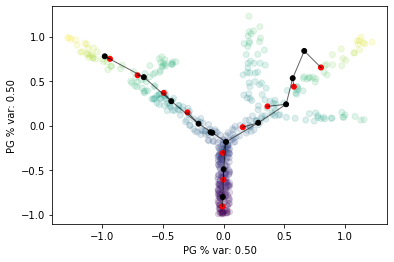

In [66]:
elpigraph.plot.PlotPG(X,{'NodePositions':MergedNodePositions,'Edges':[MergedEdges]},Do_PCA=0,
                      X_color=pseudotime, Node_color=["r" if i<nPseudoNodes else "k" for i in range(len(MergedNodePositions))])

In [700]:
elpigraph.src.grammar_operations.ApplyOptimalGraphGrammarOperation_v2(X,NodePositions,ElasticMatrix,opTypes,SquaredX=np.sum(X**2,axis=1,keepdims=1),AdjustVect =[],FixNodesAtPoints=[[0]], pseudotime=pseudotime, pseudotimeLambda=0.01,PointWeights=np.ones(len(X))[:,None])

IndexError: list index out of range

In [721]:
NewNodePositions=NodePositionsArrayAll[-1]
NodeIndicesArray=NodeIndicesArrayAll[-1]
opType=opTypesAll[-1]

In [752]:
SquaredX=np.sum(x**2,axis=1,keepdims=1)
partition, dists, precomp_d = PartitionData(x,NodePositions,SquaredX=SquaredX,MaxBlockSize=100000,precomp=True)
move_data_idx = np.where(~np.isin(partition, range(len([[0]]))))[0]
move_nodes_idx = np.arange(len([[0]]), len(NodePositions))
_partition, _dists, _d = PartitionData(x[move_data_idx],NodePositions[move_nodes_idx],SquaredX=SquaredX,MaxBlockSize=100000,precomp=True)

In [747]:
for NewNodePositions,NodeIndicesArray,opType in zip(NodePositionsArrayAll,NodeIndicesArrayAll,opTypesAll):
    partition, dists, d = PartitionData(x,NewNodePositions,SquaredX=SquaredX,MaxBlockSize=100000,precomp=True)
    partition2, dists2 = RePartitionData(x,NodePositions,NewNodePositions,NodeIndicesArray,opType,precomp_d,SquaredX,TrimmingRadius=np.inf)
    assert np.all(partition==partition2)